In [1]:
import utils
import connectome_create
# viz_method = one of ['itkwidgets', 'vtk']
viz_method = 'vtk'

# import some of our favorite packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import re
import warnings

%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
import nglui.statebuilder as ngstbld

# this is the EM specific package for querying the EM data
from caveclient import CAVEclient


from meshparty import trimesh_io, trimesh_vtk
from meshparty import skeletonize, skeleton_io, skeleton
import cloudvolume

%load_ext autoreload
%autoreload 2

query timestamp: 2024-06-27 16:00:00-07:00 (1719529200.0)


In [2]:
# client = CAVEclient()

# # if not os.path.isfile(os.path.expanduser("~/.cloudvolume/secrets/cave-secret.json")):
# client.auth.get_new_token(open=True)
# # # if you have not yet setup this computer, uncomment this below line
# # # paste the token from the website in, and run the line


In [3]:
# client.auth.save_token(token="fca0294ed408d104e0eebe74514c744b", overwrite=True)

# # # then comment or delete the line as you don't need to run it on this computer  again

In [4]:
datastack_name = 'fanc_production_mar2021'

client = CAVEclient(datastack_name)

# Create the pre_to_mn_df 
Get the MNs from the table

In [5]:
mns_df = client.materialize.query_table('leg_mn_neuropil_reftable_v0',timestamp=connectome_create.get_timestamp())
mns_df = mns_df.rename(columns={'classification_system':'muscle',
                               'cell_type':'mn_identifier',
                               'tag':'neuropil',})

mns_df = mns_df.drop('target_id',axis=1)

ref_df = client.materialize.query_table('leg_mn_order_reftable_v2',timestamp=connectome_create.get_timestamp())
mns_df = mns_df.merge(ref_df[['target_id','tag']],how='left',left_on='id',right_on='target_id')
mns_df = mns_df.rename(columns={'tag':'order'})
mns_df = mns_df.drop('target_id',axis=1)

ref_df = client.materialize.query_table('leg_mn_module_reftable_v0',timestamp=connectome_create.get_timestamp())
mns_df = mns_df.merge(ref_df[['target_id','tag']],how='left',left_on='id',right_on='target_id')
mns_df = mns_df.rename(columns={'tag':'module'})
mns_df = mns_df.drop('target_id',axis=1)


ref_df = client.materialize.query_table('leg_mn_segment_reftable_v0',timestamp=connectome_create.get_timestamp())
mns_df = mns_df.merge(ref_df[['target_id','tag']],how='left',left_on='id',right_on='target_id')
mns_df = mns_df.rename(columns={'tag':'muscle_origin'})
mns_df = mns_df.drop('target_id',axis=1)


ref_df = client.materialize.query_table('leg_mn_nerve_reftable_v0',timestamp=connectome_create.get_timestamp())
mns_df = mns_df.merge(ref_df[['target_id','tag']],how='left',left_on='id',right_on='target_id')
mns_df = mns_df.rename(columns={'tag':'nerve'})
mns_df = mns_df.drop('target_id',axis=1)

mns_df

# put them in proximal to distal by size order
mns_df['order'] = mns_df['order'].apply(lambda x: int(x))
left_t1_mns_df = mns_df.loc[mns_df['neuropil']=='left_t1']
left_t1_mns_df = left_t1_mns_df.sort_values(by='order')
left_t1_mns_df

,id_ref,created_ref,valid_ref,muscle,mn_identifier,pt_supervoxel_id,pt_root_id,id,created,neuropil,valid,pt_position,order,module,muscle_origin,nerve
0,1,2024-06-21 13:43:01.266464+00:00,t,tergopleural_promotor_pleural_promotor,tergopleural_promotor,72975275004512296,648518346487756866,1,2024-06-21 16:32:53.762720+00:00,left_t1,t,"[26759, 87253, 2174]",0,coxa_promote,thorax,DProN
1,2,2024-06-21 13:43:01.267256+00:00,t,tergopleural_promotor_pleural_promotor,tergopleural_promotor,73116080876550816,648518346491659326,2,2024-06-21 16:32:53.763276+00:00,left_t1,t,"[31494, 89253, 1423]",1,coxa_promote,thorax,DProN
2,3,2024-06-21 13:43:01.267957+00:00,t,tergopleural_promotor_pleural_promotor,pleural_promotor,72975343790906622,648518346517437482,3,2024-06-21 16:32:53.763772+00:00,left_t1,t,"[28385, 88521, 2251]",2,coxa_promote,thorax,DProN
3,4,2024-06-21 13:43:01.268646+00:00,t,tergopleural_promotor_pleural_promotor,tergopleural_promotor,72904974778207768,648518346500725685,4,2024-06-21 16:32:53.764270+00:00,left_t1,t,"[26568, 89275, 1711]",3,coxa_promote,thorax,DProN
4,5,2024-06-21 13:43:01.269310+00:00,t,sternal_anterior_rotator,VProN,72623499935890376,648518346479325585,5,2024-06-21 16:32:53.764765+00:00,left_t1,t,"[17144, 89099, 2005]",4,coxa_rotate_adduct,thorax,VProN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,65,2024-06-21 13:43:01.306578+00:00,t,tarsus_depressor,dipalpha_ventralU,73045712736535157,648518346486890393,65,2024-06-21 16:32:53.793575+00:00,left_t1,t,"[29188, 88984, 2669]",64,tarsus_depress_ventralU,tibia,ProLN
65,66,2024-06-21 13:43:01.307168+00:00,t,tarsus_depressor,A,72764169040166640,648518346472699657,66,2024-06-21 16:32:53.794048+00:00,left_t1,t,"[20633, 87133, 2615]",65,tibia_ta_flex_A,tibia,ProLN
66,67,2024-06-21 13:43:01.307751+00:00,t,tarsus_depressor,B,72764168973359401,648518346489767549,67,2024-06-21 16:32:53.794508+00:00,left_t1,t,"[21620, 87497, 2568]",66,tibia_ta_flex_B,tibia,ProLN
67,68,2024-06-21 13:43:01.308350+00:00,t,tarsus_depressor,B,72553200313457288,648518346495467855,68,2024-06-21 16:32:53.794972+00:00,left_t1,t,"[16326, 90435, 2698]",67,tibia_ta_flex_B,tibia,ProLN


Query the synapse table for pt_root_ids presynaptic to MNs

In [6]:
full_left_df = client.materialize.synapse_query(post_ids = left_t1_mns_df['pt_root_id'].to_list(),timestamp=connectome_create.get_timestamp())
print(full_left_df.shape)
# takes ~ 40 seconds,

(271679, 11)


Crosstab to get weighted directed matrix, thresholded to 3 synapses

In [7]:
df = full_left_df.loc[:,['pre_pt_root_id','post_pt_root_id']]

# Then use factorize, which encodes each occurance in a list, in this case of paired root_ids, pre and post
ij,tups = pd.factorize(list(zip(*map(df.get,df))))

# Then create a dictionary out of each occurance, storing the number of factorized codes
result = dict(zip(tups, np.bincount(ij)))

# Finally, turn the result into series, with the tuples of pt_root_ids as the multiindex
tupseries = pd.Series(result)

thresh = 3
# Finally, threshold by the connection strength and perfom the unstack operation
thresholdedtupseries = tupseries[tupseries>=thresh]
prelim_pre_df = thresholdedtupseries.unstack(fill_value=0)
print(prelim_pre_df.shape)


(3900, 69)


Order the columns according to the mn df, add the mn matrix as a frame

In [8]:
pre_to_mn_df = prelim_pre_df.loc[:,left_t1_mns_df['pt_root_id'].to_list()]
mnmi_df = left_t1_mns_df[['module','nerve','muscle_origin','muscle','mn_identifier','order','pt_root_id']]
mnmi_df = mnmi_df.rename(columns={'pt_root_id':'segID'})
pre_to_mn_df.columns = pd.MultiIndex.from_frame(mnmi_df)
pre_to_mn_df.head()

module                                       coxa_promote                     \
nerve                                               DProN                      
muscle_origin                                      thorax                      
muscle             tergopleural_promotor_pleural_promotor                      
mn_identifier                       tergopleural_promotor                      
order                                                  0                  1    
segID                                  648518346487756866 648518346491659326   
648518346491241505                                      0                 27   
648518346510172454                                      0                  0   
648518346486783228                                      3                  0   
648518346489554629                                      0                  0   
648518346482940581                                      0                  0   

module                                                       \
nerve                                                         
muscle_origin                                                 
muscle                                                        
mn_identifier        pleural_promotor tergopleural_promotor   
order                              2                     3    
segID              648518346517437482    648518346500725685   
648518346491241505                  0                    22   
648518346510172454                  0                     0   
648518346486783228                  0                     0   
648518346489554629                  0                     0   
648518346482940581                  0                     0   

module                   coxa_rotate_adduct                     \
nerve                                 VProN                      
muscle_origin                        thorax                      
muscle             sternal_anterior_rotator                      
mn_identifier                         VProN                      
order                                    4                  5    
segID                    648518346479325585 648518346487504531   
648518346491241505                        0                  0   
648518346510172454                        0                  0   
648518346486783228                        0                  0   
648518346489554629                        0                  0   
648518346482940581                        0                  0   

module                                              coxa_posterior  \
nerve                           ProAN                        ProAN   
muscle_origin                  thorax                       thorax   
muscle               sternal_adductor pleural_remotor_and_abductor   
mn_identifier                   ProAN                            ?   
order                              6                            7    
segID              648518346478125293           648518346479077839   
648518346491241505                  0                            0   
648518346510172454                  0                            0   
648518346486783228                  0                            0   
648518346489554629                  0                            0   
648518346482940581                  0                            0   

module                                                           ...  \
nerve                                                            ...   
muscle_origin                                                    ...   
muscle                                sternal_posterior_rotator  ...   
mn_identifier                                    posterior_soma  ...   
order                              8                         9   ...   
segID              648518346483047589        648518346490738941  ...   
648518346491241505                  4                         0  ...   
648518346510172454                  0                         0  ...   


In [9]:
soma_table = client.materialize.query_table('neuron_somas_dec2022',timestamp=connectome_create.get_timestamp())
neckns_df = client.materialize.query_table('neck_connective',timestamp=connectome_create.get_timestamp())
all_sensory = connectome_create.get_unduplicated_sensory_axon_table(client)

pmn_index = pre_to_mn_df.index.to_frame()
pmn_index.rename(columns={0:'segID'},inplace=True)
pmn_index['motor'] = pmn_index.segID.isin(mnmi_df.segID)
pmn_index['has_soma'] = pmn_index.segID.isin(soma_table.pt_root_id)
pmn_index['sensory'] = pmn_index.segID.isin(all_sensory.pt_root_id)
pmn_index['neck'] = pmn_index.segID.isin(neckns_df.pt_root_id)
pmn_index['local'] = False
pmn_index.neck.sum(axis=0)
pre_to_mn_df.index = pd.MultiIndex.from_frame(pmn_index)

In [10]:
pre_to_mn_df.sum().sum()
# total synapse count in the connectivity matrix after thresholding

233581

# Sort the matrix rows

In [11]:
s = pre_to_mn_df.sum(axis=1)
pre_to_mn_df = pre_to_mn_df.loc[s.sort_values(ascending=False).index,:]

# Create cell_class

In [12]:
All = slice(None)

### Motor neurons
# segID	motor	has_soma	sensory	 neck	local	
m_r_tup = (All,True,All,All,All,All)
mns = pre_to_mn_df.loc[m_r_tup,:]
mns = mns.loc[mns.sum(axis=1).sort_values(ascending=False).index,:]
print('mns shape: {}'.format(mns.shape))

### sensory neurons
# segID	motor	has_soma	sensory	 neck	local	
s_r_tup = (All,False,False,True,False,False)
sensory = pre_to_mn_df.loc[s_r_tup,:]
sensory = sensory.loc[sensory.sum(axis=1).sort_values(ascending=False).index,:]
print('sensory shape: {}'.format(sensory.shape))

### descending neurons
# segID	motor	has_soma	sensory	 neck	local	
descending = pre_to_mn_df.loc[(All,False,False,False,True,All),:]
descending = descending.loc[descending.sum(axis=1).sort_values(ascending=False).index,:]
print('descending shape: {}'.format(descending.shape))

### How many ascending neurons # 138
# segID	motor	has_soma	sensory	 neck	local	
ascending = pre_to_mn_df.loc[(All,False,True,False,True,False),:]
ascending = ascending.loc[ascending.sum(axis=1).sort_values(ascending=False).index,:]
print('ascending shape: {}'.format(ascending.shape))

### VNC neurons
# segID	motor	has_soma	sensory	 neck	local	
vncns = pre_to_mn_df.loc[(All,False,True,False,False,False),:]
vncns = vncns.loc[vncns.sum(axis=1).sort_values(ascending=False).index,:]
print('vncns shape: {}'.format(vncns.shape))

## strange motor neurons
sensmns = pre_to_mn_df.loc[(All,False,True,True,False,False),:]
sensmns = sensmns.loc[sensmns.sum(axis=1).sort_values(ascending=False).index,:]
print('sensmns shape: {}'.format(sensmns.shape))

(mns.shape[0]+sensory.shape[0]+descending.shape[0] + ascending.shape[0] + vncns.shape[0] + sensmns.shape[0] )

# Neurons with a soma and not ascending
fragments = pre_to_mn_df.loc[(All,False,False,False,False,False),:].copy()
### VNC neurons
# segID	motor	has_soma	sensory	 neck	local	
fragments = pre_to_mn_df.loc[(All,False,False,False,False,False),:]
fragments = fragments.loc[fragments.sum(axis=1).sort_values(ascending=False).index,:]

mns shape: (37, 69)
sensory shape: (189, 69)
descending shape: (227, 69)
ascending shape: (179, 69)
vncns shape: (982, 69)
sensmns shape: (1, 69)


In [13]:
connectome_create.save_pre_to_mn_df(pre_to_mn_df,ext='edited')

.\dfs_pre_to_mn\pre_to_mn_df_edited_20240627.pkl
(3900, 69)


In [14]:
ordered_pMN_to_MN_df = pd.concat([
    mns,
    descending,
    sensory,
    vncns,
    ascending,
    sensmns,
    fragments
])
print(ordered_pMN_to_MN_df.shape)

(3900, 69)


In [15]:
connectome_create.save_pre_to_mn_df(ordered_pMN_to_MN_df,ext='ordered')

.\dfs_pre_to_mn\pre_to_mn_df_ordered_20240627.pkl
(3900, 69)


In [16]:
pre_to_mn_df = ordered_pMN_to_MN_df # connectome_create.load_pre_to_mn_df(ext='ordered')

# Plot connectivity

Show fragments

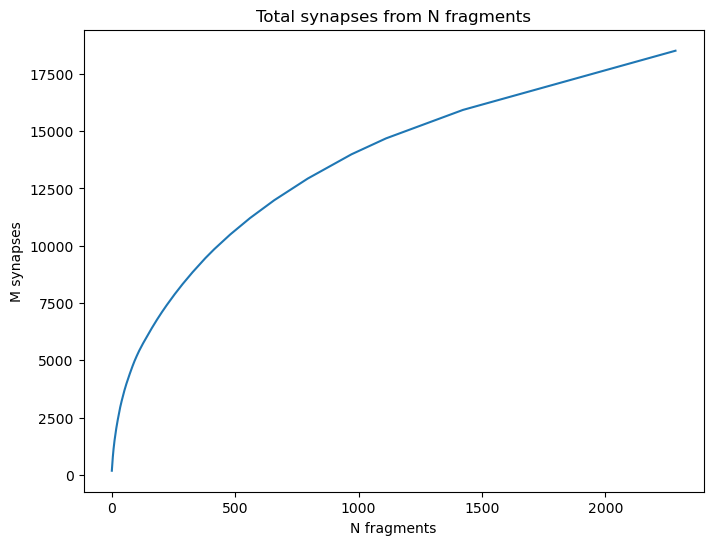

In [17]:
total = fragments.sum(axis=1)
tot = total.cumsum()#/total.sum() # The fraction of total input from a given fragment
n = np.array([i for i in range(len(tot))])  # assign a number to neurons
frc = n/n.sum()

fig = plt.figure(1, figsize=(8, 6))
ax1 = plt.subplot2grid((1,1),(0,0))

# ax1.scatter(x, y)
ax1.plot(n,tot)#, marker='o')
plt.sca(ax1)
plt.title('Total synapses from N fragments')
plt.ylabel('M synapses')
plt.xlabel('N fragments')
plt.show()
# locs, labels = plt.xticks(ticks=x, labels=lbls, rotation=90)

In [18]:
fragments

module                                                                          coxa_promote  \
nerve                                                                                  DProN   
muscle_origin                                                                         thorax   
muscle                                                tergopleural_promotor_pleural_promotor   
mn_identifier                                                          tergopleural_promotor   
order                                                                                     0    
segID                                                                     648518346487756866   
segID              motor has_soma sensory neck  local                                          
648518346496171837 False False    False   False False                                      0   
648518346493984369 False False    False   False False                                      0   
648518346501199126 False False    False   False False                                      0   
648518346499841605 False False    False   False False                                     11   
648518346493931889 False False    False   False False                                      0   
...                                                                                      ...   
648518346470374354 False False    False   False False                                      0   
648518346531638042 False False    False   False False                                      0   
648518346479312482 False False    False   False False                                      0   
648518346479395594 False False    False   False False                                      0   
648518346491364917 False False    False   False False                                      3   

module                                                                    \
nerve                                                                      
muscle_origin                                                              
muscle                                                                     
mn_identifier                                                              
order                                                                 1    
segID                                                 648518346491659326   
segID              motor has_soma sensory neck  local                      
648518346496171837 False False    False   False False                  0   
648518346493984369 False False    False   False False                 31   
648518346501199126 False False    False   False False                  0   
648518346499841605 False False    False   False False                  0   
648518346493931889 False False    False   False False                  0   
...                                                                  ...   
648518346470374354 False False    False   False False                  0   
648518346531638042 False False    False   False False                  0   
648518346479312482 False False    False   False False                  0   
648518346479395594 False False    False   False False                  0   
648518346491364917 False False    False   False False                  0   

module                                                                    \
nerve                                                                      
muscle_origin                                                              
muscle                                                                     
mn_identifier                                           pleural_promotor   
order                                                                 2    
segID                                                 648518346517437482   
segID              motor has_soma sensory neck  local                      
648518346496171837 False False    False   False False                  0   
648518346493984369 False False    False   Fals

Confirm that the ordering is correct by plotting the sum of the synapses

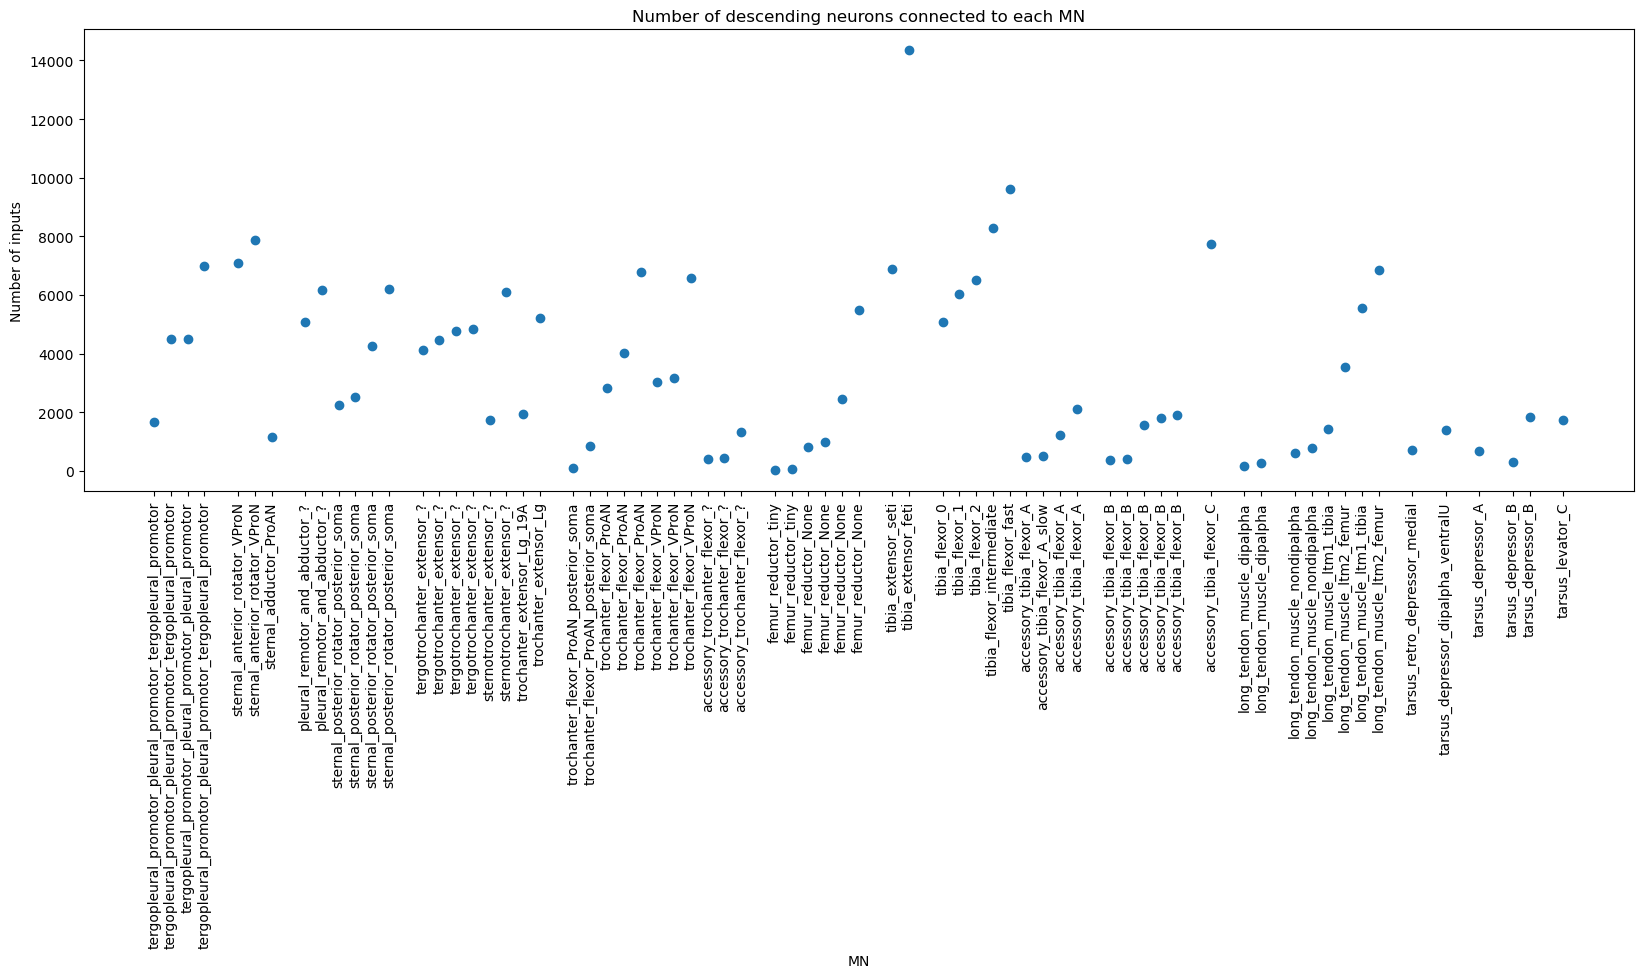

In [19]:
# Create x_ticks separate by modules
x =[0]
cnt = 0
while cnt<mnmi_df.shape[0]-1:
    if mnmi_df['module'][cnt+1]==mnmi_df['module'][cnt]:
        x = x + [x[cnt]+1]
    else:
        x= x + [x[cnt]+2]
    cnt=cnt+1

lbls = [i + '_' + str(j) for i,j in zip(mnmi_df['muscle'],mnmi_df['mn_identifier'])]

y = pre_to_mn_df.to_numpy().sum(axis=0)

fig = plt.figure(1, figsize=(20, 6))
ax1 = plt.subplot2grid((1,1),(0,0))

ax1.scatter(x, y,marker='o')
plt.sca(ax1)
plt.title('Number of descending neurons connected to each MN')
plt.xlabel('MN')
plt.ylabel('Number of inputs')
locs, labels = plt.xticks(ticks=x, labels=lbls, rotation=90)

# plt.savefig('./figpanels/total_inputs.svg',format='svg')

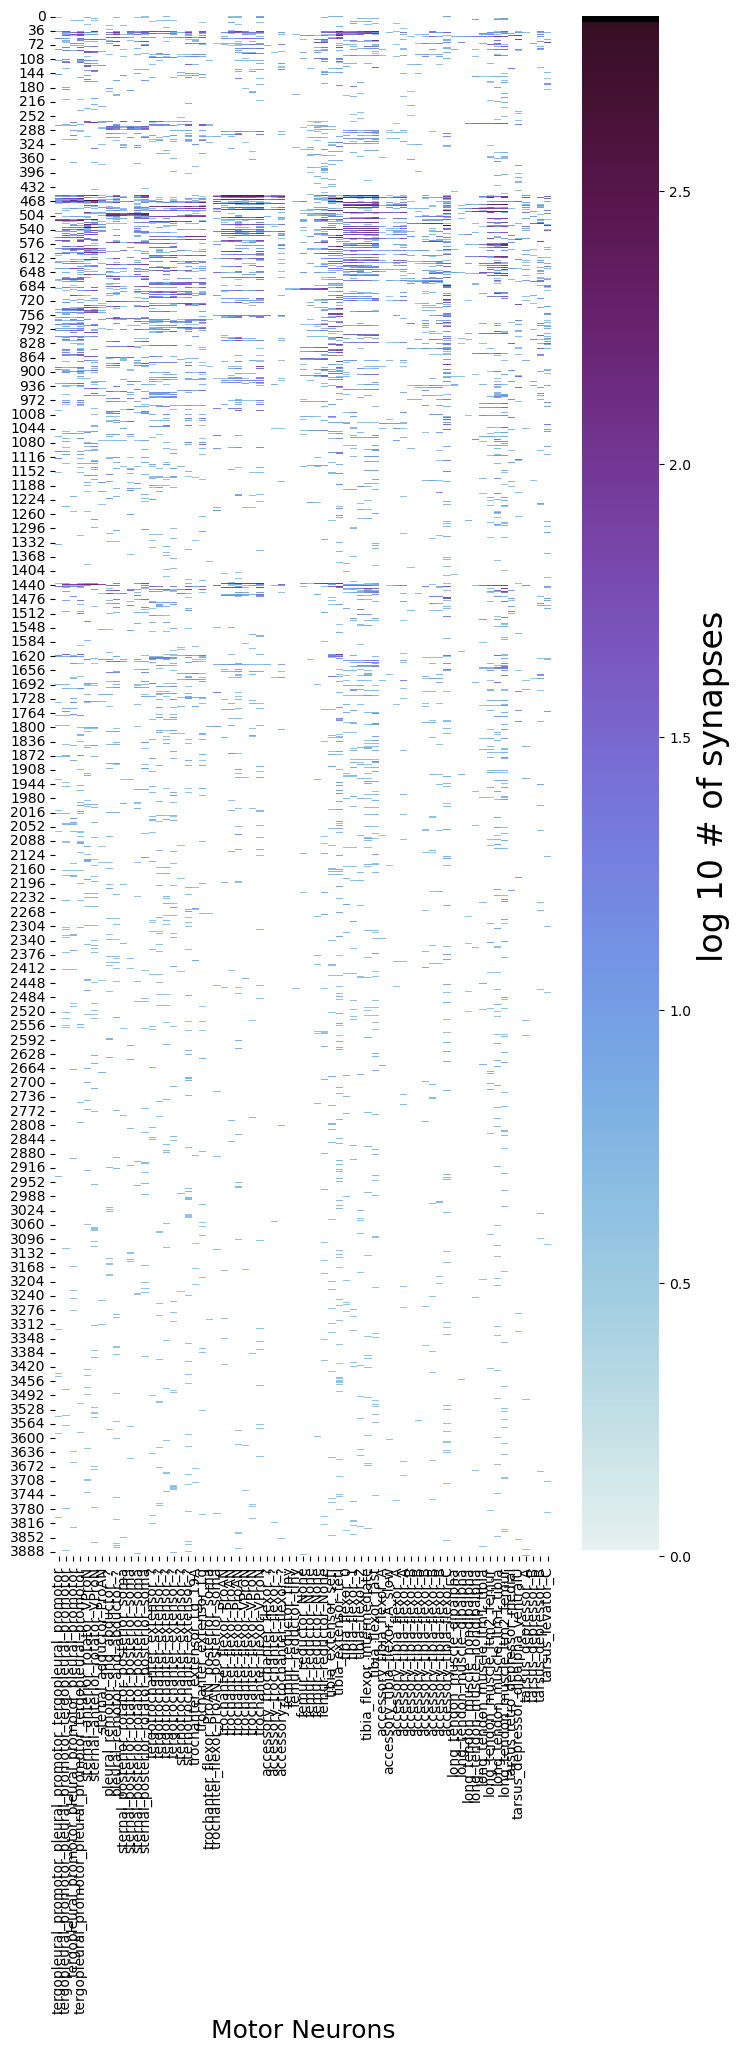

In [20]:
lbls = lbls


fig = plt.figure(1, figsize = [8,20])
cmap = utils.white_dense()
ax = sns.heatmap(np.log10(pre_to_mn_df.to_numpy()+1), xticklabels=lbls, cmap=cmap)
ax.set_rasterized(True)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'log 10 # of synapses', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
# plt.ylabel(ylabelstring, fontsize =18)
# plt.yticks(fontsize = 16)
# plt.xticks(fontsize = 16)
# plt.show()

# plt.xlabel(None)
# plt.ylabel(None)
# plt.xticks([])
# plt.yticks([])
plt.show()


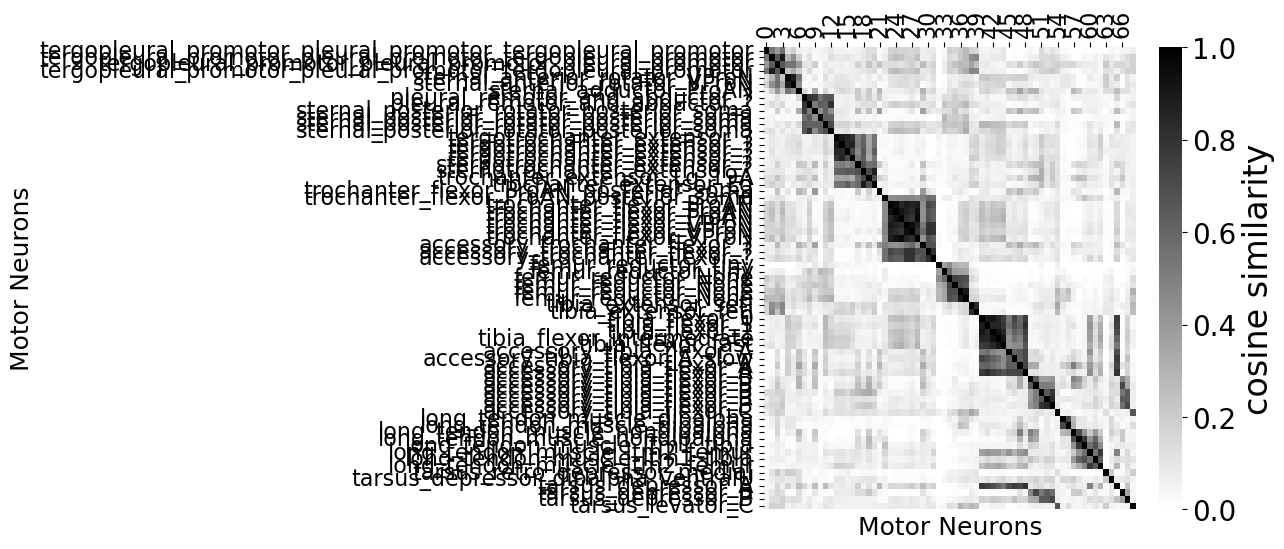

In [21]:
cos_cmap = sns.color_palette('gray_r', as_cmap=True)

lbls = lbls

sim_mat = cosine_similarity(pre_to_mn_df.to_numpy().transpose())
fig = plt.figure(1, figsize = [6,6])
ax = sns.heatmap(sim_mat, yticklabels=lbls,cmap=cos_cmap,vmin=0, vmax=1)
ax.xaxis.set_ticks_position('top')
cbar = ax.collections[0].colorbar
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'cosine similarity', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
plt.ylabel('Motor Neurons', fontsize =18)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.show()

# fig.savefig('./figpanels/cos_sim_all_grayscale_cmo.svg',format='svg')

# Load Premotor connectivity matrix

In [22]:
pre_to_mn_df

module                                                                          coxa_promote  \
nerve                                                                                  DProN   
muscle_origin                                                                         thorax   
muscle                                                tergopleural_promotor_pleural_promotor   
mn_identifier                                                          tergopleural_promotor   
order                                                                                     0    
segID                                                                     648518346487756866   
segID              motor has_soma sensory neck  local                                          
648518346466168368 True  True     False   False False                                      0   
648518346495952784 True  True     True    False False                                      0   
648518346483445438 True  True     False   False False                                      3   
648518346514306270 True  True     False   False False                                      0   
648518346494148128 True  True     True    False False                                      0   
...                                                                                      ...   
648518346470374354 False False    False   False False                                      0   
648518346531638042 False False    False   False False                                      0   
648518346479312482 False False    False   False False                                      0   
648518346479395594 False False    False   False False                                      0   
648518346491364917 False False    False   False False                                      3   

module                                                                    \
nerve                                                                      
muscle_origin                                                              
muscle                                                                     
mn_identifier                                                              
order                                                                 1    
segID                                                 648518346491659326   
segID              motor has_soma sensory neck  local                      
648518346466168368 True  True     False   False False                  0   
648518346495952784 True  True     True    False False                  3   
648518346483445438 True  True     False   False False                  0   
648518346514306270 True  True     False   False False                  0   
648518346494148128 True  True     True    False False                  0   
...                                                                  ...   
648518346470374354 False False    False   False False                  0   
648518346531638042 False False    False   False False                  0   
648518346479312482 False False    False   False False                  0   
648518346479395594 False False    False   False False                  0   
648518346491364917 False False    False   False False                  0   

module                                                                    \
nerve                                                                      
muscle_origin                                                              
muscle                                                                     
mn_identifier                                           pleural_promotor   
order                                                                 2    
segID                                                 648518346517437482   
segID              motor has_soma sensory neck  local                      
648518346466168368 True  True     False   False False                  0   
648518346495952784 True  True     True    Fals

# Test suite

In [23]:
All = slice(None)

# # How many motor neurons are presynaptic to motor neurons
# # segID	motor	has_soma	sensory	 neck	local	
motor = pre_to_mn_df.loc[(All,True,True,All,False,False),:]
# descending.index.get_level_values('segID').to_list()
print(motor.shape)

# How many sensory neurons # 94
# segID	motor	has_soma	sensory	 neck	local	
sensory = pre_to_mn_df.loc[(All,False,False,True,False,False),:]
# descending.index.get_level_values('segID').to_list()
print(sensory.shape)

# How many descending neurons # 217 214?
# segID	motor	has_soma	sensory	 neck	local	
descending = pre_to_mn_df.loc[(All,False,False,False,True),:]
# descending.index.get_level_values('segID').to_list()
print(descending.shape)

# How many motor neurons are presynaptic to motor neurons
# segID	motor	has_soma	sensory	 neck	local	
ascending = pre_to_mn_df.loc[(All,False,True,False,True,False),:]
# descending.index.get_level_values('segID').to_list()
print(ascending.shape)
# some ascending that should be ascending
# 648518346507084872
# 648518346480786912
# 648518346490374748
sid = 648518346504729203
ascending.index.get_level_values('segID')==sid
# All are here

# Fragments?
# segID	motor	has_soma	sensory	 neck	local	
sensmns = pre_to_mn_df.loc[(All,False,True,True,False,False),:]
print(sensmns.shape)

# Fragments?
# segID	motor	has_soma	sensory	 neck	local	
fragments = pre_to_mn_df.loc[(All,False,False,False,False,False),:]
print(fragments.shape)

# Local and intersegmental? # 880
# segID	motor	has_soma	sensory	 neck	local	
vncns = pre_to_mn_df.loc[(All,False,True,False,False,False),:]
# descending.index.get_level_values('segID').to_list()
print(vncns.shape)


(37, 69)
(189, 69)
(227, 69)
(179, 69)
(1, 69)
(2285, 69)
(982, 69)


In [24]:
pre_to_mn_df

module                                                                          coxa_promote  \
nerve                                                                                  DProN   
muscle_origin                                                                         thorax   
muscle                                                tergopleural_promotor_pleural_promotor   
mn_identifier                                                          tergopleural_promotor   
order                                                                                     0    
segID                                                                     648518346487756866   
segID              motor has_soma sensory neck  local                                          
648518346466168368 True  True     False   False False                                      0   
648518346495952784 True  True     True    False False                                      0   
648518346483445438 True  True     False   False False                                      3   
648518346514306270 True  True     False   False False                                      0   
648518346494148128 True  True     True    False False                                      0   
...                                                                                      ...   
648518346470374354 False False    False   False False                                      0   
648518346531638042 False False    False   False False                                      0   
648518346479312482 False False    False   False False                                      0   
648518346479395594 False False    False   False False                                      0   
648518346491364917 False False    False   False False                                      3   

module                                                                    \
nerve                                                                      
muscle_origin                                                              
muscle                                                                     
mn_identifier                                                              
order                                                                 1    
segID                                                 648518346491659326   
segID              motor has_soma sensory neck  local                      
648518346466168368 True  True     False   False False                  0   
648518346495952784 True  True     True    False False                  3   
648518346483445438 True  True     False   False False                  0   
648518346514306270 True  True     False   False False                  0   
648518346494148128 True  True     True    False False                  0   
...                                                                  ...   
648518346470374354 False False    False   False False                  0   
648518346531638042 False False    False   False False                  0   
648518346479312482 False False    False   False False                  0   
648518346479395594 False False    False   False False                  0   
648518346491364917 False False    False   False False                  0   

module                                                                    \
nerve                                                                      
muscle_origin                                                              
muscle                                                                     
mn_identifier                                           pleural_promotor   
order                                                                 2    
segID                                                 648518346517437482   
segID              motor has_soma sensory neck  local                      
648518346466168368 True  True     False   False False                  0   
648518346495952784 True  True     True    Fals

# Find intersegmental neurons
Go through the vnc premotor neurons and look for a synapse outside the left hand box.
Once you find one, move to the next premotor neuron

In [25]:
# Soma box
soma_table = client.materialize.query_table('somas_dec2022',timestamp=connectome_create.get_timestamp())
# soma_table.index = soma_table.pt_root_id
print(soma_table.shape)
soma_table = soma_table.drop_duplicates(subset=['pt_root_id'])
print(soma_table.shape)
soma_table.index = soma_table.pt_root_id

(16764, 10)
(16754, 10)


In [26]:
sx = [-3000, 3000]
sy = [-3000, 3000]
sz = [-300, 300]

# T1 bounding box, click on neuroglancer instance
All = slice(None)
x = [3000 , 38000]
y = [90483, 123190] # extended the boundaries a bit 5/10/22
z = [980, 3858]

t1 = lambda b: (b[0]>=x[0]) & (b[0]<=x[1]) & (b[1]>=y[0]) & (b[1]<=y[1]) & (b[2]>=z[0]) & (b[2]<=z[1])

def get_non_T1_inputs(iln_syn_df, s):
    in_T1_box = iln_syn_df.loc[:,['post_pt_position']].applymap(t1)
    pts_out_of_T1 = iln_syn_df.loc[~in_T1_box.post_pt_position,:]
    pts_in_T1 = iln_syn_df.loc[in_T1_box.post_pt_position,:]
    nearsoma = lambda b: (b[0]>=s[0]+sx[0]) & (b[0]<=s[0]+sx[1]) & (b[1]>=s[1]+sy[0]) & (b[1]<=s[1]+sy[1]) & (b[2]>=s[2]+sz[0]) & (b[2]<=s[2]+sz[1])
    in_soma_box = pts_out_of_T1.loc[:,['post_pt_position']].applymap(nearsoma)
    pts_out_of_T1 = pts_out_of_T1.loc[~in_soma_box.post_pt_position,:]
    return pts_out_of_T1

In [27]:
from datetime import date
vncnsindex = vncns.index.to_frame()
vncnsindex.index = vncnsindex.index.get_level_values('segID')
vncnsindex['non_T1_count'] = 0

row_i = 0
row_f = 99
cnt = 0
while row_i<vncnsindex.shape[0]:
    print('Querying [{}:{}]'.format(row_i,row_f))
    rows_df = vncnsindex.iloc[row_i:row_f,:]
    iln_syn_df = client.materialize.synapse_query(post_ids = rows_df.index.get_level_values('segID').to_list(),timestamp=connectome_create.get_timestamp())
    for idx in rows_df.index.get_level_values('segID').to_list():
        try:
            s=soma_table.loc[idx,:].pt_position
        except KeyError:
            if 'fraglist' not in locals():
                today = date.today()
                d1 = today.strftime("%Y%m%d")
                fn = './dfs_saved/' + 'frag_df' + '_' + d1 + '.pkl'
                fraglist= pd.read_pickle(fn)
            if sid in fraglist.pt_root_id.to_list():
                print('{} is a known fragment of a local neuron'.format(sid))
                vncnsindex.loc[idx,'local'] = True
        
        non_T1_inputs = get_non_T1_inputs(iln_syn_df.loc[iln_syn_df['post_pt_root_id']==idx], s)
        if non_T1_inputs.empty:
            #print('{} is local'.format(sid))
            vncnsindex.loc[idx,'local'] = True
        else: 
            #print('{} has {} inputs outside of T1'.format(sid,non_T1_inputs.shape[0]))
            vncnsindex.loc[idx,'non_T1_count'] = non_T1_inputs.shape[0]
        
    print('Done [{}:{}]'.format(row_i,row_f))
    row_i = row_f+1
    row_f = min([row_i+99,vncnsindex.shape[0]])
    
vncns.index = pd.MultiIndex.from_frame(vncnsindex)


Querying [0:99]
Done [0:99]
Querying [100:199]
Done [100:199]
Querying [200:299]
Done [200:299]
Querying [300:399]
Done [300:399]
Querying [400:499]
Done [400:499]
Querying [500:599]
Done [500:599]
Querying [600:699]
Done [600:699]
Querying [700:799]
Done [700:799]
Querying [800:899]
Done [800:899]
Querying [900:982]
Done [900:982]


# Reconcatenate dataframes

In [28]:
mnindex= motor.index.to_frame()
mnindex.index = mnindex.index.get_level_values('segID')
mnindex['non_T1_count'] = 0
motor.index = pd.MultiIndex.from_frame(mnindex)

descindex= descending.index.to_frame()
descindex.index = descindex.index.get_level_values('segID')
descindex['non_T1_count'] = 0
descending.index = pd.MultiIndex.from_frame(descindex)

sensoryindex= sensory.index.to_frame()
sensoryindex.index = sensoryindex.index.get_level_values('segID')
sensoryindex['non_T1_count'] = 0
sensory.index = pd.MultiIndex.from_frame(sensoryindex)

ascindex= ascending.index.to_frame()
ascindex.index = ascindex.index.get_level_values('segID')
ascindex['non_T1_count'] = 0
ascending.index = pd.MultiIndex.from_frame(ascindex)

sensmnsindex= sensmns.index.to_frame()
sensmnsindex.index = sensmnsindex.index.get_level_values('segID')
sensmnsindex['non_T1_count'] = 0
sensmns.index = pd.MultiIndex.from_frame(sensmnsindex)

frgindex= fragments.index.to_frame()
frgindex.index = frgindex.index.get_level_values('segID')
frgindex['non_T1_count'] = 0
fragments.index = pd.MultiIndex.from_frame(frgindex)

ordered_pMN_to_MN_df = pd.concat([
    motor,
    descending,
    sensory,
    vncns,
    ascending,
    sensmns,
    fragments,
])

In [29]:
connectome_create.save_pre_to_mn_df(ordered_pMN_to_MN_df,ext='vncns_inter_vs_local')

.\dfs_pre_to_mn\pre_to_mn_df_vncns_inter_vs_local_20240627.pkl
(3900, 69)


# Reorder

In [30]:
# segID	motor	has_soma	sensory	 neck	local	
pre_to_mn_df = ordered_pMN_to_MN_df

m_r_tup = (All,True,All,All,All,All)
motor = pre_to_mn_df.loc[m_r_tup,:]
motor = motor.loc[motor.sum(axis=1).sort_values(ascending=False).index,:]
print(motor.shape)

### sensory neurons
# segID	motor	has_soma	sensory	 neck	local	
s_r_tup = (All,False,False,True,False,False)
sensory = pre_to_mn_df.loc[s_r_tup,:]
sensory = sensory.loc[sensory.sum(axis=1).sort_values(ascending=False).index,:]
print(sensory.shape)

### weird mn neurons
# segID	motor	has_soma	sensory	 neck	local	
w_r_tup = (All,False,True,True,False,False)
sensmns = pre_to_mn_df.loc[w_r_tup,:]
sensmns = sensmns.loc[sensmns.sum(axis=1).sort_values(ascending=False).index,:]
print(sensmns.shape)

### descending neurons
# segID	motor	has_soma	sensory	 neck	local	
descending = pre_to_mn_df.loc[(All,False,False,False,True,All),:]
descending = descending.loc[descending.sum(axis=1).sort_values(ascending=False).index,:]
print(descending.shape)

### How many ascending neurons # 138
# segID	motor	has_soma	sensory	 neck	local	
ascending = pre_to_mn_df.loc[(All,False,True,False,True,False),:]
ascending = ascending.loc[ascending.sum(axis=1).sort_values(ascending=False).index,:]
print(ascending.shape)

### VNC neurons
# segID	motor	has_soma	sensory	 neck	local	
vncns = pre_to_mn_df.loc[(All,False,True,False,False,All,All),:]
vncns = vncns.loc[vncns.sum(axis=1).sort_values(ascending=False).index,:]
print(vncns.shape)

fragments = pre_to_mn_df.loc[(All,False,False,False,False,False),:]
fragments.shape

(37, 69)
(189, 69)
(1, 69)
(227, 69)
(179, 69)
(982, 69)


(2285, 69)

# Reclassify
Should some of these be local neurons instead?

In [31]:

local = vncns.loc[(All,False,True,False,False,True,All),:]
print('local shape:{}'.format(local.shape))

# peel off some local neurons from the intersegmental neurons
intrseg = vncns.loc[(All,False,True,False,False,False,All),:]
print('inter shape:{}'.format(intrseg.shape))

index = intrseg.index.to_frame()
index.index = index.index.get_level_values('segID')
somenonT1 = index.non_T1_count<20
intrseg.loc[somenonT1.to_list(),:]

possible_local = intrseg.loc[somenonT1.to_list(),:]
print(possible_local.shape)

# Order local_p by numbers of synapses
local_p = pd.concat([local,possible_local])
local_p = local_p.loc[local_p.sum(axis=1).sort_values(ascending=False).index,:]

intrseg_m = intrseg.loc[~somenonT1.to_numpy(),:]

print(intrseg_m.shape)

# Print the next tranche of neurons to see if any others should be typed and local
mi,arr = intrseg_m.index.sortlevel(level='non_T1_count')
mi_df = mi.to_frame()
# .loc[].segID
    # utils.save_df_csv(mi_df.loc[mi_df.non_T1_count<100],name='possible_local_from_intersegmental')
possible_local_str = [str(x) for x in mi_df.loc[mi_df.non_T1_count<100].segID.to_list()]
possible_local_state = utils.make_json(possible_local_str,name='Are these local?')

# Now just look for that giant 19B neuron and move it to the local stack
pmns = pd.DataFrame()
pmns['pt_position'] = [[52132, 120825, 1557]]

# looking to add this one particular neuron:
cv = cloudvolume.CloudVolume(client.info.get_datastack_info()['segmentation_source'], use_https=True)
segID = utils.segIDs_from_pts_service(pmns.pt_position,cv)

if any(pre_to_mn_df.index.get_level_values('segID').isin([segID[0]])):
    print('Moving large neuron {} from intersegmental to local group'.format(segID))
    local_p = pd.concat([local_p,intrseg_m.loc[segID]])
    local_p = local_p.loc[local_p.sum(axis=1).sort_values(ascending=False).index,:]


locidx = local_p.index.to_frame()
# locidx.index = locidx.index.get_level_values('segID').to_list()
locidx.local = True
locmi = pd.MultiIndex.from_frame(locidx)
local_p.index = locmi
print(local_p.shape)

intrseg_m = intrseg_m.loc[mi_df.segID!=segID[0],:]
print('local shape:{} ({})'.format(local_p.shape,locidx.local.sum()))
print('inter shape:{}'.format(intrseg_m.shape))

local shape:(588, 69)
inter shape:(394, 69)
(89, 69)
(305, 69)
Getting segIDs
using .json
Moving large neuron [648518346489985111] from intersegmental to local group
(678, 69)
local shape:(678, 69) (678)
inter shape:(304, 69)


In [32]:
client.info.get_datastack_info()

{'aligned_volume': {'id': 7,
  'name': 'fanc_v4',
  'display_name': 'FANC',
  'description': 'FANC (pronounced "fancy") is the Female Adult Nerve Cord, a GridTape-TEM dataset of an adult female Drosophila melanogaster\\\'s ventral nerve cord. Visit https://fanc.community for more information.',
  'image_source': 'precomputed://gs://lee-lab_female-adult-nerve-cord/alignmentV4/em/rechunked'},
 'segmentation_source': 'graphene://https://cave.fanc-fly.com/segmentation/table/mar2021_prod',
 'analysis_database': None,
 'viewer_site': 'https://neuroglancer-demo.appspot.com/',
 'synapse_table': 'synapses_nov2022',
 'soma_table': 'neuron_somas_dec2022',
 'local_server': 'https://cave.fanc-fly.com',
 'description': 'This is the first version of the fanc dataset hosted in CAVE.',
 'viewer_resolution_x': 4.3,
 'viewer_resolution_y': 4.3,
 'viewer_resolution_z': 45.0,
 'proofreading_status_table': 'proofread_first_pass',
 'cell_identification_table': None,
 'proofreading_review_table': None}

In [33]:
local_p.head()
segID[0]
# local_p.loc[648518346480658945]

648518346489985111

In [34]:
ngl_base = 'https://neuromancer-seung-import.appspot.com/'
new_id = client.state.upload_state_json(possible_local_state)
client.state.build_neuroglancer_url(new_id, ngl_base)

'https://neuromancer-seung-import.appspot.com/?json_url=https://global.daf-apis.com/nglstate/api/v1/5320496636755968'

## Sort cell classes by similarity onto mns

### Descending neurons

In [35]:
#print(descending.shape)
sim_mat = cosine_similarity(descending.to_numpy())

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)

# plot the top three levels of the dendrogram
clustered_order = utils.plot_dendrogram(model, truncate_mode="level", p=6000) # p truncate mode
clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
# print(clustered_order)
descending_clustered = descending.iloc[clustered_order,:].copy()
descending_clustered.shape

(227, 69)

### sensory neurons

In [36]:
sim_mat = cosine_similarity(sensory.to_numpy())

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)

# plot the top three levels of the dendrogram
clustered_order = utils.plot_dendrogram(model, truncate_mode="level", p=6000) # p truncate mode
clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
# print(clustered_order)
sensory_clustered = sensory.iloc[clustered_order,:].copy()
sensory_clustered.shape

(189, 69)

### local neurons

In [37]:
sim_mat = cosine_similarity(local_p.to_numpy())

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)

# plot the top three levels of the dendrogram
clustered_order = utils.plot_dendrogram(model, truncate_mode="level", p=6000) # p truncate mode
clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
# print(clustered_order)
local_clustered = local_p.iloc[clustered_order,:].copy()
local_clustered.shape

(678, 69)

### intersegmental neurons

In [38]:
sim_mat = cosine_similarity(intrseg_m.to_numpy())

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)

# plot the top three levels of the dendrogram
clustered_order = utils.plot_dendrogram(model, truncate_mode="level", p=6000) # p truncate mode
clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
# print(clustered_order)
intrseg_clustered = intrseg_m.iloc[clustered_order,:].copy()
intrseg_clustered.shape

(304, 69)

In [39]:
sim_mat = cosine_similarity(ascending.to_numpy())

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)

# plot the top three levels of the dendrogram
clustered_order = utils.plot_dendrogram(model, truncate_mode="level", p=6000) # p truncate mode
clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
# print(clustered_order)
ascending_clustered = ascending.iloc[clustered_order,:].copy()
ascending_clustered.shape

(179, 69)

In [40]:
clustered_pMN_to_MN_df = pd.concat([
    motor,
    descending_clustered,
    sensory_clustered,
    intrseg_clustered,
    local_p, # local_clustered,
    ascending_clustered,
    sensmns,
    fragments
])
print(clustered_pMN_to_MN_df.shape)

clustered_pMN_to_MN_df_no_frags = pd.concat([
    descending_clustered,
    sensory_clustered,
    intrseg_clustered,
    local_p, # local_clustered,
    ascending_clustered,
])
print(clustered_pMN_to_MN_df_no_frags.shape)

clustered_pMN_to_MN_df_with_clusteredvnc = pd.concat([
    descending_clustered,
    sensory_clustered,
    intrseg_clustered,
    local_clustered,
    ascending_clustered,
])
print(clustered_pMN_to_MN_df_with_clusteredvnc.shape)

# ordered_pMN_to_MN_df_no_desc = pd.concat([
#     sensory,
#     vncns,
#     ascending
# ])
# print(ordered_pMN_to_MN_no_desc_df.shape)


# ordered_pMN_to_MN_df_all = pd.concat([
#     descending,
#     sensory,
#     vncns,
#     ascending,
#     fragments
# ])
# print(ordered_pMN_to_MN_df_all.shape)


(3900, 69)
(1577, 69)
(1577, 69)


# Save the clustered_pMN_to_MN_df

In [41]:
connectome_create.save_pre_to_mn_df(clustered_pMN_to_MN_df,ext='clustered_ordered')

.\dfs_pre_to_mn\pre_to_mn_df_clustered_ordered_20240627.pkl
(3900, 69)


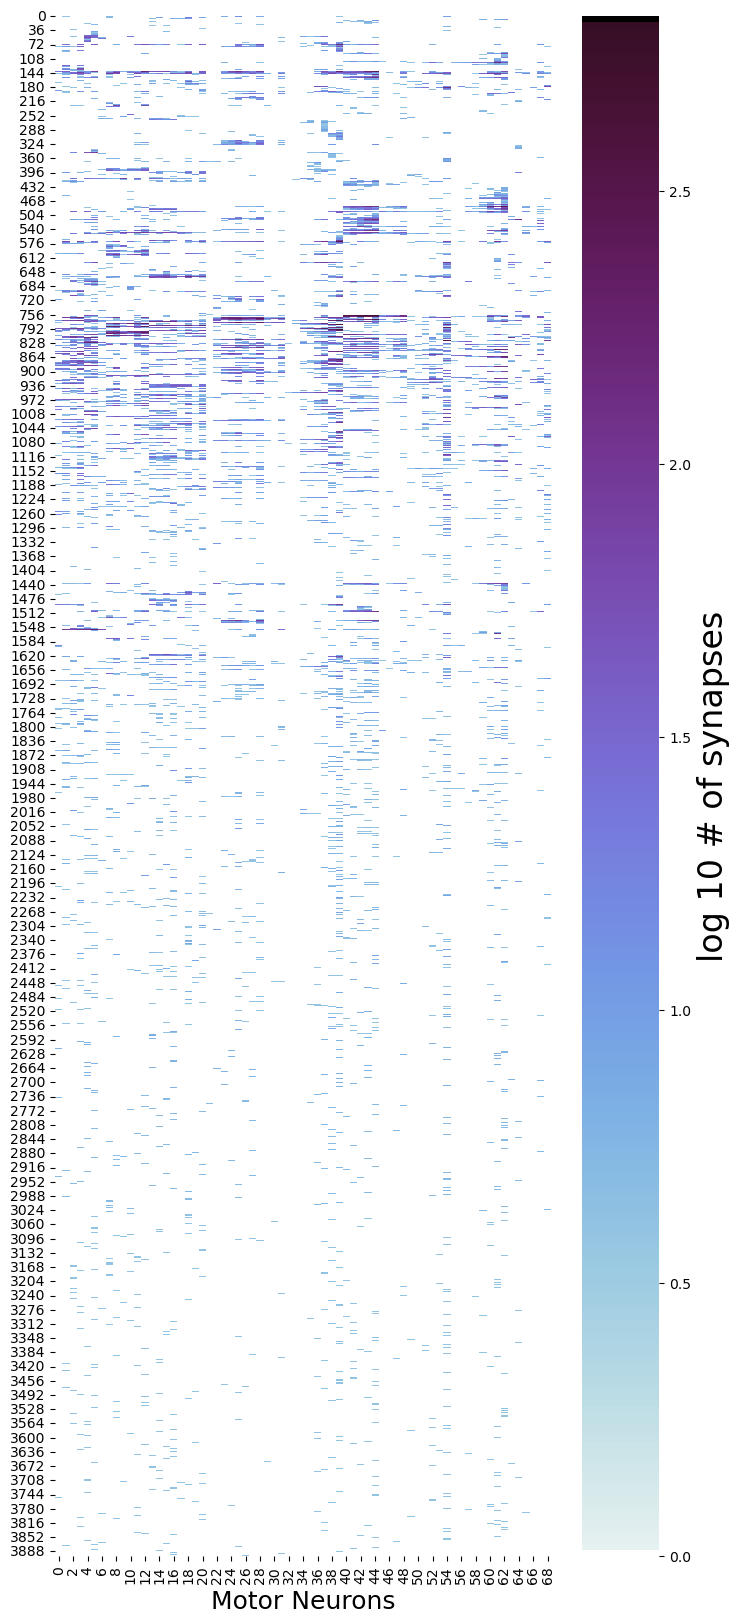

In [42]:
lbls = [i + '_' + str(j) for i,j in zip(clustered_pMN_to_MN_df.columns.get_level_values('muscle').to_list(),clustered_pMN_to_MN_df.columns.get_level_values('mn_identifier').to_list())]
# dns = clustered_pMN_to_MN_df.loc['descending']

fig = plt.figure(1, figsize = [8,20])
cmap = utils.white_dense()
ax = sns.heatmap(np.log10(clustered_pMN_to_MN_df.to_numpy()+1), cmap=cmap)
ax.set_rasterized(True)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'log 10 # of synapses', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
# plt.ylabel(ylabelstring, fontsize =18)
# plt.yticks(fontsize = 16)
# plt.xticks(fontsize = 16)
# plt.show()

# plt.xlabel(None)
# plt.ylabel(None)
# plt.xticks([])
# plt.yticks([])
plt.show()


# Load Motor neuron table and determine cell classes 
My current hierarchy would be: Region (brain,vnc,descending,ascending), segment (T1,2,3,Ab), class (motor, sensory, intersegmental, local), neurotransmitter, primary neurite bundle/hemilineage, type

In [43]:
all_pre_to_mn_df = clustered_pMN_to_MN_df # connectome_create.load_pre_to_mn_df(ext='clustered_ordered')

all_pre_to_mn_df['cell_class']  = ''
print(all_pre_to_mn_df.shape)

All = slice(None)
                    # segID	motor	has_sma	sensory	neck	local   T1_count
all_pre_to_mn_df.loc[(All,  True,   True,   False,  False,  False,  All),'cell_class'] = 'motor'
all_pre_to_mn_df.loc[(All,  True,   True,   True,  False,  False,  All),'cell_class'] = 'motor'
all_pre_to_mn_df.loc[(All,  False,  False,    True,   False,  False,  All),'cell_class'] = 'sensory' 
all_pre_to_mn_df.loc[(All,  False,  True,    True,   False,  False,  All),'cell_class'] = 'sensemns' # always has those weird neurons in there
all_pre_to_mn_df.loc[(All,  False,  False,  False,  True,   False,  All),'cell_class'] = 'descending'
all_pre_to_mn_df.loc[(All,  False,  True,   False,  True,   False,  All),'cell_class'] = 'ascending'
all_pre_to_mn_df.loc[(All,  False,  False,  False,  False,  False,  All),'cell_class'] = 'fragment'
all_pre_to_mn_df.loc[(All,  False,  True,   False,  False,  True,   All),'cell_class'] = 'local'
all_pre_to_mn_df.loc[(All,  False,  True,   False,  False,  False,  All),'cell_class'] = 'intersegmental'
print(all_pre_to_mn_df.cell_class.value_counts())

all_pre_to_mn_df = all_pre_to_mn_df.set_index(keys=['cell_class'],append=True,drop=True,verify_integrity=True)
all_pre_to_mn_df = all_pre_to_mn_df.reset_index(level=['motor','has_soma','sensory','neck','local','non_T1_count'],drop=True)
all_pre_to_mn_df = all_pre_to_mn_df.reorder_levels(['cell_class','segID'],'index')
print(all_pre_to_mn_df.shape)

pre_to_mn_df = all_pre_to_mn_df.loc[(['descending','sensory','intersegmental','local','ascending']),:]
print(pre_to_mn_df.shape)

pre_to_mn_df.head()


# Note 8/2/22 - the the sensory group is currently 117. This includes 111 actual sensory neurons, likely after some proofreading. 
# Then there are 6 sensory neurons with somas. This should change on 8/3, there are still the bilateral mns, but some of the sensory snarls have been proofread


(3900, 70)
cell_class
fragment          2285
local              678
intersegmental     304
descending         227
sensory            189
ascending          179
motor               37
sensemns             1
Name: count, dtype: int64
(3900, 69)
(1577, 69)


module                                                  coxa_promote  \
nerve                                                          DProN   
muscle_origin                                                 thorax   
muscle                        tergopleural_promotor_pleural_promotor   
mn_identifier                                  tergopleural_promotor   
order                                                              0   
segID                                             648518346487756866   
cell_class segID                                                       
descending 648518346493969399                                      0   
           648518346496558594                                      0   
           648518346498261041                                      0   
           648518346466652526                                      0   
           648518346479324635                                      0   

module                                                               \
nerve                                                                 
muscle_origin                                                         
muscle                                                                
mn_identifier                                      pleural_promotor   
order                                          1                  2   
segID                         648518346491659326 648518346517437482   
cell_class segID                                                      
descending 648518346493969399                  0                  0   
           648518346496558594                  0                  0   
           648518346498261041                  0                  0   
           648518346466652526                  0                  0   
           648518346479324635                  0                  0   

module                                                    coxa_rotate_adduct  \
nerve                                                                  VProN   
muscle_origin                                                         thorax   
muscle                                              sternal_anterior_rotator   
mn_identifier                 tergopleural_promotor                    VProN   
order                                             3                        4   
segID                            648518346500725685       648518346479325585   
cell_class segID                                                               
descending 648518346493969399                     0                        0   
           648518346496558594                     0                        7   
           648518346498261041                     0                        0   
           648518346466652526                     0                        0   
           648518346479324635                     0                        0   

module                                                               \
nerve                                                         ProAN   
muscle_origin                                                thorax   
muscle                                             sternal_adductor   
mn_identifier                                                 ProAN   
order                                          5                  6   
segID                         648518346487504531 648518346478125293   
cell_class segID                                                      
descending 648518346493969399                 16                  0   
           648518346496558594                 28                  0   
           648518346498261041                  7                  0   
           648518346466652526                 35                  0   
           648518346479324635                  3                  0   

module                                      coxa_posterior                     \
nerve                                                ProAN                      
muscle_origi

In [44]:
connectome_create.save_pre_to_mn_df(all_pre_to_mn_df,ext='pre_match_to_pool_w_fragments')

.\dfs_pre_to_mn\pre_to_mn_df_pre_match_to_pool_w_fragments_20240627.pkl
(3900, 69)


# Assigning preMNs to motor modules
This script answers the following question: Is there a stable match where we can assign a local premotor neuron to a muscle group?
The idea comes from the med school matching algorithm and aims to produce an order to the premotor neurons where the "most important" neurons for a given muscle is assigned to that muscle. This will allow us to look at the connectivity of the local premotors and say, e.g., "this important neuron for tibia flexors is also connected to femur flexors". So, what does "important" mean? To assign premotors to motor modules, for each premotor neuron, we rank the motor modules by the number of combined inputs to the motor modules. For each motor modules, we rank premotor neurons by their contribution to the cluster unit vector. Then we let the matching algorithm work on those rankings. This ranking system is premotor/student optimal, and the lists for the motor modules/school are not limited, so it should aggregate premotor neurons just to their prefered module.

In [45]:
pre_to_mn_df = all_pre_to_mn_df.loc[(['descending','sensory','intersegmental','local','ascending']),:]

In [46]:
# cell_class = cell_class.loc[(All,pool_keys,All),:]

# mpool_dict = utils.get_motor_pool_tuple_dict()
# pool_keys = utils.atomized_pools()
# cell_class_keys = [k for k in pool_keys if k in cell_class.index.get_level_values('preferred_pool').unique().to_list()]
# cell_class_keys

If the module have already been assigned, and there is a level of the column multi index, then this search for motor pools is simple

In [48]:
import utils
mnmi_df = pre_to_mn_df.columns.to_frame()
if mnmi_df.columns.values[0] == 'module':
    mpool_dict = utils.simple_motor_pool_dict_map()
else:
    mpool_dict = utils.get_motor_pool_tuple_dict()

pool_keys = utils.ta_assigned_pools_coxa_ab()


In [49]:
pref_total_df = pre_to_mn_df.groupby(level='module',axis=1).sum()
pref_total_df = pref_total_df[pool_keys]

max_value_columns = pref_total_df.idxmax(axis=1)

idx = pre_to_mn_df.index.to_frame()
idx['preferred_pool'] = max_value_columns

cell_class_cat = pd.api.types.CategoricalDtype(categories=['descending','sensory','ascending','intersegmental','local'], ordered=True)
pool_cat = pd.api.types.CategoricalDtype(categories=pool_keys, ordered=True)

idx['cell_class'] = idx['cell_class'].astype(cell_class_cat)
idx['preferred_pool'] = idx['preferred_pool'].astype(pool_cat)

idx['outputsynapse_inverse'] = pref_total_df.sum(axis=1).astype(float)**-1

idx = idx[['cell_class','preferred_pool','outputsynapse_inverse','segID']]

new_new_pre_to_mn_df = pre_to_mn_df.copy()
new_new_pre_to_mn_df.index = pd.MultiIndex.from_frame(idx)

new_new_pre_to_mn_df.sort_index(level=['cell_class','preferred_pool','outputsynapse_inverse'],inplace=True,kind='stable')
new_new_pre_to_mn_df = new_new_pre_to_mn_df.droplevel(level='outputsynapse_inverse',axis=0)

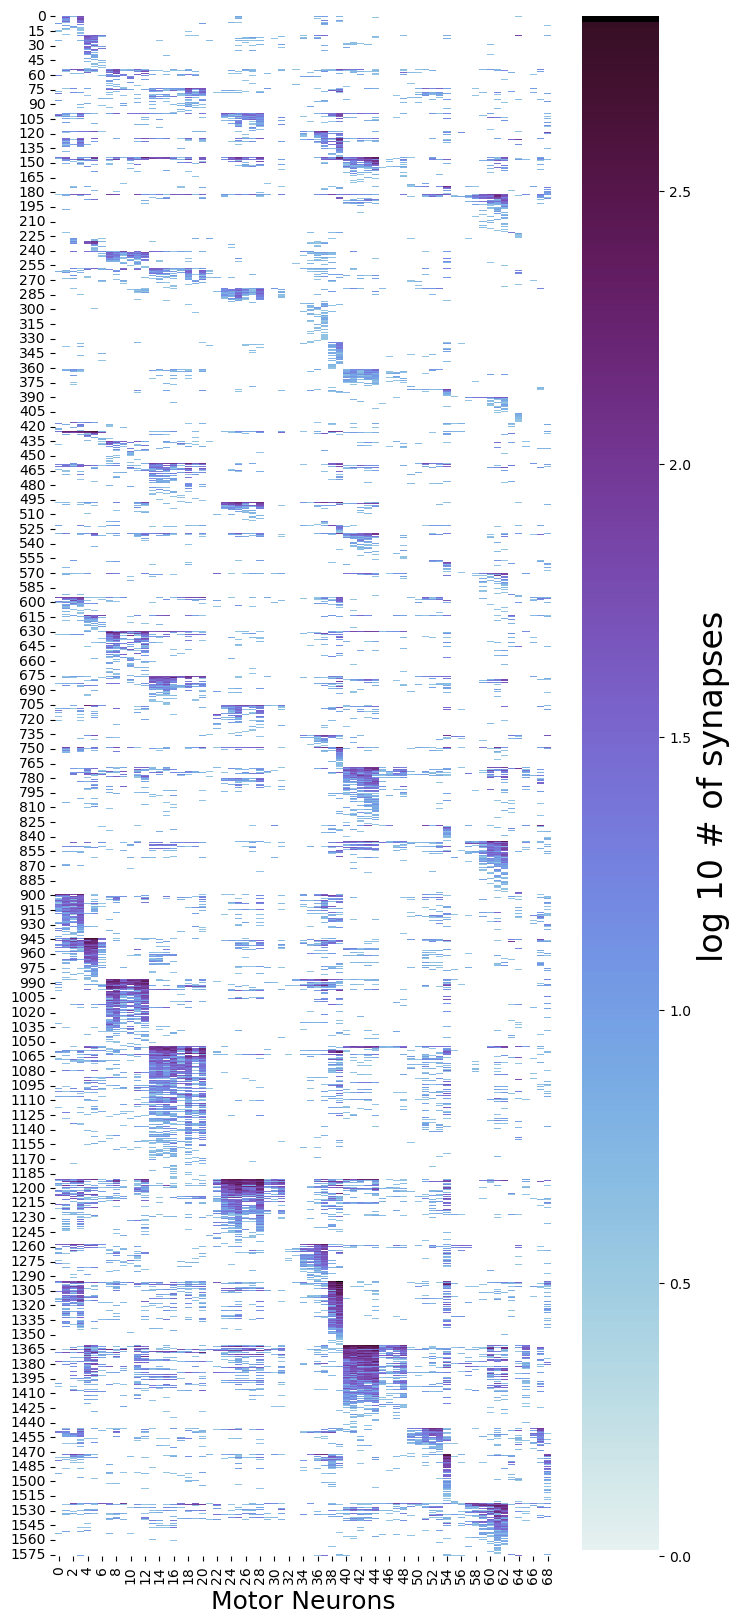

In [50]:
lbls = [i + '_' + str(j) for i,j in zip(new_new_pre_to_mn_df.columns.get_level_values('muscle').to_list(),new_new_pre_to_mn_df.columns.get_level_values('mn_identifier').to_list())]
# dns = clustered_pMN_to_MN_df.loc['descending']

fig = plt.figure(1, figsize = [8,20])
cmap = utils.white_dense()
ax = sns.heatmap(np.log10(new_new_pre_to_mn_df.to_numpy()+1), cmap=cmap)
ax.set_rasterized(True)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'log 10 # of synapses', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
# plt.ylabel(ylabelstring, fontsize =18)
# plt.yticks(fontsize = 16)
# plt.xticks(fontsize = 16)
# plt.show()

# plt.xlabel(None)
# plt.ylabel(None)
# plt.xticks([])
# plt.yticks([])
plt.show()


In [51]:
# all_pre_to_mn_df.sum().sum()
# new_pre_to_mn.sum().sum()

In [52]:
connectome_create.save_pre_to_mn_df(new_new_pre_to_mn_df,ext='matched_to_pool')
pre_to_mn_df = new_new_pre_to_mn_df

.\dfs_pre_to_mn\pre_to_mn_df_matched_to_pool_20240627.pkl
(1577, 69)


# Add local neuron classification and hemilineage to matrix

In [53]:
client.materialize.get_tables()

['wing_motor_neuron_table_v0',
 'soma_jan2022',
 'synapses_nov2022',
 'proofread_second_pass',
 'cell_ids_v2',
 'motor_neuron_table_v7',
 'proofreading_status_jasper',
 'somas_dec2022',
 'upstream_feco_axons',
 'nucleus_mar2022',
 'left_t3_mn_order_reftable_v0',
 'downstream_feco_axons_v1',
 'synapse_regions_v1',
 'neuron_somas_dec2022',
 'topo_23b_table_v0',
 'downstream_10b_table_v0',
 'downstream_hair_plate_axon_table_v0',
 'proofread_by_andrewcook',
 'peripheral_nerves',
 'grooming_command_like_neurons_v1',
 'feco_axons_v0',
 'glia_somas_dec2022',
 'gustatory_downstream_t1l',
 'legcs_axons',
 'upstream_hair_plate_axon_table_v0',
 'sensory_admn_left',
 'left_t1_local_premotor_table_v5',
 'neck_connective',
 'right_t2_mn_cell_type_table_v0',
 'right_t3_mn_cell_type_table_v0',
 'abdominal_sensory_axon_table_v0',
 'neurotransmitter_hemilineage_table',
 'downstream_feco_axons_v0',
 'right_t2_mn_order_reftable_v0',
 'hair_plate_table',
 'downstream_bristle_table_v0',
 'bristle_axon_table

In [54]:
pmn_annotation_table = client.materialize.query_table('left_t1_local_premotor_table_v6',timestamp=connectome_create.get_timestamp())
# pmn_annotation_table = client.materialize.live_live_query('left_t1_local_premotor_table_v6',timestamp=connectome_create.get_timestamp())

# pmn_annotation_table.classification_system.value_counts()
# pmn_annotation_table.cell_type.value_counts()

In [55]:
# how many of the pmn seg is are not in the matrix
pmn_index = pre_to_mn_df.index.to_frame()
pmn_index = pmn_index.set_index(keys=['segID'],drop=False)
local_pmns  = pmn_index.loc[pmn_index.cell_class=='local']


local_pmns_to_type = local_pmns.loc[~local_pmns.segID.isin(pmn_annotation_table.pt_root_id)]
utils.save_df_csv(local_pmns_to_type,name='left_t1_local_premns_to_type')
local_pmns_to_type.segID.to_list()

./dfs_saved/left_t1_local_premns_to_type_20240627.csv
(16, 3)


[648518346494841109,
 648518346512932766,
 648518346501424406,
 648518346478948468,
 648518346524340229,
 648518346494850615,
 648518346486841340,
 648518346486985697,
 648518346504193230,
 648518346498475346,
 648518346496054635,
 648518346467270663,
 648518346493052078,
 648518346492269330,
 648518346518387030,
 648518346492792505]

In [56]:
inter_pmns  = pmn_index.loc[pmn_index.cell_class=='intersegmental']
utils.save_df_csv(inter_pmns,name='left_t1_inter_premns_to_type')

./dfs_saved/left_t1_inter_premns_to_type_20240627.csv
(304, 3)


In [57]:
# just add classifications and hemilineage to the index, then put the index back on and reorder
pmn_index = pre_to_mn_df.index.to_frame()
pmn_index = pmn_index.set_index(keys=['segID'],drop=False)

pmn_index['classification_system'] = None
pmn_index['cell_type'] = None

for clsys in pmn_annotation_table.classification_system.unique():
    pmn_index.loc[pmn_index.segID.isin(pmn_annotation_table.loc[pmn_annotation_table.classification_system==clsys,'pt_root_id']),'classification_system'] = clsys
    
for ctype in pmn_annotation_table.cell_type.unique():
    pmn_index.loc[pmn_index.segID.isin(pmn_annotation_table.loc[pmn_annotation_table.cell_type==ctype,'pt_root_id']),'cell_type'] = ctype

pre_to_mn_df.index = pd.MultiIndex.from_frame(pmn_index)
pre_to_mn_df = pre_to_mn_df.reorder_levels(['cell_class','preferred_pool','classification_system','cell_type','segID'],'index')

# Add neurotransmitters

## Create lookuptable

In [58]:
classification_system = pre_to_mn_df.index.get_level_values('classification_system').unique().to_numpy()

nt_table = pd.read_csv('./annotations_hl/LacinHLTable.csv')
hl_lut = {'classification_system':classification_system,'hemilineage':classification_system}
hl_lut = pd.DataFrame(data=hl_lut)


In [59]:

for idx,r in hl_lut.iterrows():
    try:
        if np.isnan(r.hemilineage):
            continue
    except TypeError:
        pass
    hl = r.hemilineage
    
    hl_lut.loc[idx,'hemilineage'] = hl

# merge with neurotransmitter table to get a lookuptable
hl_lut = hl_lut.merge(nt_table,how='outer',left_on='hemilineage',right_on='HL')
hl_lut = hl_lut.loc[~hl_lut.hemilineage.isna(),:]

hl_lut_reduced = hl_lut[['classification_system','NT']]
# just operate on the index, where the nt will be
pmn_index_df = pre_to_mn_df.index.to_frame().reset_index(drop=True)

# join the index on cell_type, with NT
pmn_index_df = pmn_index_df.join(hl_lut_reduced.set_index('classification_system'),how='left',on='classification_system')

# reorder the matrix
pmn_index_df = pmn_index_df[['cell_class','preferred_pool','NT','classification_system','cell_type','segID']]
pmn_index_df.NT.value_counts()

NT
Ach     300
GABA    195
Glu     180
Name: count, dtype: int64

# Classify sensory neurons

In [60]:
all_sensory = connectome_create.get_unduplicated_sensory_axon_table(client)

all_sensory = all_sensory[['pt_root_id','classification_system','cell_type']]
all_sensory = all_sensory.rename({'pt_root_id':'segID'},axis=1)

# join the index on cell_type, with NT
pmn_index_df = pmn_index_df.merge(all_sensory,how='left',on='segID',suffixes=['_x','_y'])

sens_rows = (pmn_index_df.cell_class == 'sensory') & (pmn_index_df.classification_system_x.isna())
pmn_index_df.loc[sens_rows,'classification_system_x'] = pmn_index_df.loc[sens_rows].classification_system_y
pmn_index_df.loc[sens_rows,'cell_type_x'] = pmn_index_df.loc[sens_rows].cell_type_y

pmn_index_df.loc[pmn_index_df.cell_class == 'sensory','NT'] = 'Ach'
pmn_index_df = pmn_index_df.drop(['classification_system_y','cell_type_y'],axis=1)
pmn_index_df = pmn_index_df.rename(columns={'classification_system_x':'classification_system','cell_type_x':'cell_type'})

pre_to_mn_df.index = pd.MultiIndex.from_frame(pmn_index_df)

glia = pre_to_mn_df[pre_to_mn_df.index.get_level_values('cell_type') == 'Gial_error']
no_glia = pre_to_mn_df[pre_to_mn_df.index.get_level_values('cell_type') != 'Gial_error']

In [61]:
pmn_index_df.shape

(1577, 6)

In [62]:
connectome_create.save_pre_to_mn_df(no_glia,ext='matched_typed_with_nt')

.\dfs_pre_to_mn\pre_to_mn_df_matched_typed_with_nt_20240627.pkl
(1562, 69)


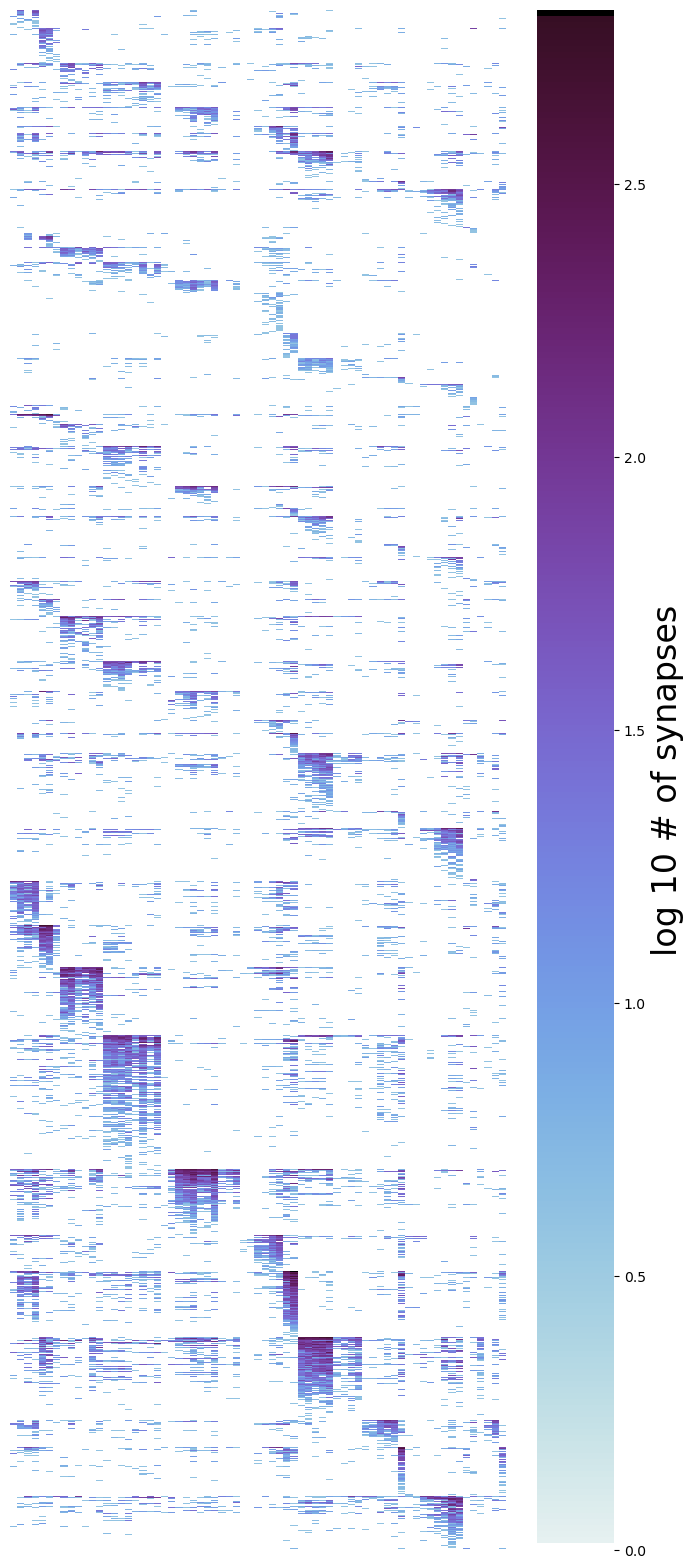

True


In [63]:
lbls = [i + '_' + str(j) for i,j in zip(no_glia.columns.get_level_values('muscle').to_list(),no_glia.columns.get_level_values('mn_identifier').to_list())]
dns = pre_to_mn_df.loc['descending']

fig = plt.figure(1, figsize = [8,20])
cmap = utils.white_dense()
ax = sns.heatmap(np.log10(no_glia.to_numpy()+1), xticklabels=lbls, cmap=cmap)
ax.set_rasterized(True)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'log 10 # of synapses', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
# plt.ylabel(ylabelstring, fontsize =18)
# plt.yticks(fontsize = 16)
# plt.xticks(fontsize = 16)
# plt.show()

plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
plt.yticks([])
plt.show()

fig2 = ax.get_figure()
print(fig==fig2)
# fig.savefig('./figpanels/matched_premotor_to_motor.eps',format='eps',dpi=300, bbox_inches='tight')
fig.savefig('./figpanels/matched_premotor_to_motor.svg',format='svg',transparent=True,dpi=600)

# Compute all numbers

In [64]:
def elements(df,name):
    print('{}: {}, {} total'.format(name, df.shape, df.sum().sum()))
    return df.sum().sum()


In [65]:
all_pre_to_mn_df.index.get_level_values(level='cell_class').unique()

Index(['motor', 'descending', 'sensory', 'intersegmental', 'local',
       'ascending', 'sensemns', 'fragment'],
      dtype='object', name='cell_class')

In [66]:
all = elements(all_pre_to_mn_df,'all_pre_to_mn_df')
pmn = elements(no_glia,'preMNs only')
gia = elements(glia,'glia sensory snarls')
frg = elements(all_pre_to_mn_df.loc['fragment'],'fragments')
mtr = elements(all_pre_to_mn_df.loc['motor'],'motor')
sms = elements(all_pre_to_mn_df.loc['sensemns'],'sensmns')

total_syn = pmn + gia + frg + mtr + sms
print(total_syn)
print(all)

all_pre_to_mn_df: (3900, 69), 233581 total
preMNs only: (1562, 69), 214307 total
glia sensory snarls: (15, 69), 214 total
fragments: (2285, 69), 18512 total
motor: (37, 69), 544 total
sensmns: (1, 69), 4 total
233581
233581


In [67]:
all_pre_to_mn_df.loc['sensemns']

module                                       coxa_promote                     \
nerve                                               DProN                      
muscle_origin                                      thorax                      
muscle             tergopleural_promotor_pleural_promotor                      
mn_identifier                       tergopleural_promotor                      
order                                                   0                  1   
segID                                  648518346487756866 648518346491659326   
segID                                                                          
648518346494308722                                      0                  0   

module                                                       \
nerve                                                         
muscle_origin                                                 
muscle                                                        
mn_identifier        pleural_promotor tergopleural_promotor   
order                               2                     3   
segID              648518346517437482    648518346500725685   
segID                                                         
648518346494308722                  0                     0   

module                   coxa_rotate_adduct                     \
nerve                                 VProN                      
muscle_origin                        thorax                      
muscle             sternal_anterior_rotator                      
mn_identifier                         VProN                      
order                                     4                  5   
segID                    648518346479325585 648518346487504531   
segID                                                            
648518346494308722                        0                  0   

module                                              coxa_posterior  \
nerve                           ProAN                        ProAN   
muscle_origin                  thorax                       thorax   
muscle               sternal_adductor pleural_remotor_and_abductor   
mn_identifier                   ProAN                            ?   
order                               6                            7   
segID              648518346478125293           648518346479077839   
segID                                                                
648518346494308722                  0                            0   

module                                                           ...  \
nerve                                                            ...   
muscle_origin                                                    ...   
muscle                                sternal_posterior_rotator  ...   
mn_identifier                                    posterior_soma  ...   
order                               8                         9  ...   
segID              648518346483047589        648518346490738941  ...   
segID                                                            ...   
648518346494308722                  0                         0  ...   

module                          ltm_B                                        \
nerve                           ProLN                                         
muscle_origin                     ltm                                         
muscle             long_tendon_muscle                                         
mn_identifier              ltm1_tibia         ltm2_femur         ltm1_tibia   
order                              59                 60                 61   
segID              648518346486352776 648518346510155558 648518346486617760   
segID                                                                         
648518346494308722                  0                  0                  0   

module                                 tarsus_depress_medial  \
nerve                                                  ProLN

In [68]:
frg/all

0.07925302143581883

In [69]:
glia.columns.get_level_values('segID').to_list()

[648518346487756866,
 648518346491659326,
 648518346517437482,
 648518346500725685,
 648518346479325585,
 648518346487504531,
 648518346478125293,
 648518346479077839,
 648518346483047589,
 648518346490738941,
 648518346489802071,
 648518346491281272,
 648518346488854257,
 648518346514458155,
 648518346496195084,
 648518346520685366,
 648518346486850812,
 648518346514306270,
 648518346504092878,
 648518346502617767,
 648518346497891062,
 648518346477140752,
 648518346481524623,
 648518346466168368,
 648518346495952784,
 648518346505044358,
 648518346488137239,
 648518346483445438,
 648518346488873565,
 648518346504230496,
 648518346490899373,
 648518346479197392,
 648518346487743188,
 648518346486427296,
 648518346519022303,
 648518346503310971,
 648518346477726990,
 648518346494195703,
 648518346494148128,
 648518346507389983,
 648518346479239887,
 648518346498314906,
 648518346479055568,
 648518346496932836,
 648518346489543513,
 648518346491774737,
 648518346496059082,
 648518346478

In [70]:
print('no frag')
print(new_new_pre_to_mn_df.shape)
print(new_new_pre_to_mn_df.sum().sum())

# fragments
print('fragments')
print(all_pre_to_mn_df.loc['fragment'].shape)
print(all_pre_to_mn_df.loc['fragment'].sum().sum())

print('glia')
print(glia.shape)
print(glia.sum().sum())

print('no glia no fragments')
print(no_glia.shape)
print(no_glia.sum().sum())

print(no_glia.sum().sum()+all_pre_to_mn_df.loc['fragment'].sum().sum()+glia.sum().sum())
print(new_new_pre_to_mn_df.sum().sum()+all_pre_to_mn_df.loc['fragment'].sum().sum()+glia.sum().sum())

no frag
(1577, 69)
214521
fragments
(2285, 69)
18512
glia
(15, 69)
214
no glia no fragments
(1562, 69)
214307
233033
233247


In [71]:
new_new_pre_to_mn_df.sum().sum()

214521

# Examine subsets of the connectivity

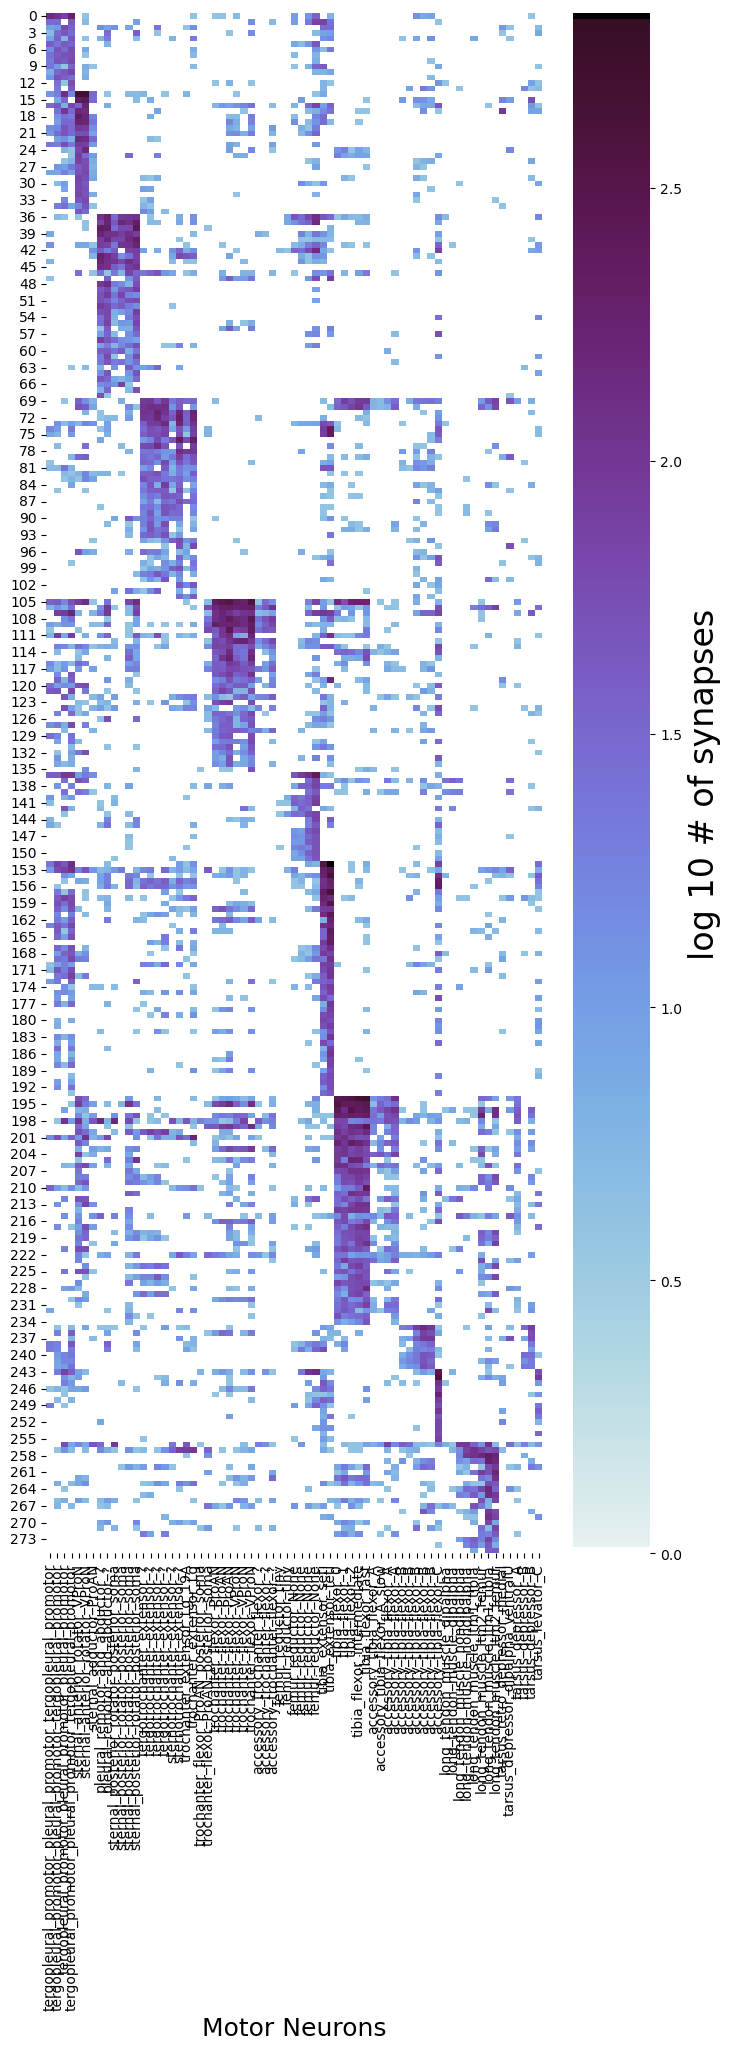

In [72]:
lbls = [i + '_' + str(j) for i,j in zip(no_glia.columns.get_level_values('muscle').to_list(),no_glia.columns.get_level_values('mn_identifier').to_list())]
dns = pre_to_mn_df.loc['descending']
lcl = no_glia.loc['local']
lcl = lcl.loc[(lcl>40).any(axis=1),:]

fig = plt.figure(1, figsize = [8,20])
cmap = utils.white_dense()
ax = sns.heatmap(np.log10(lcl.to_numpy()+1), xticklabels=lbls, cmap=cmap)
ax.set_rasterized(True)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'log 10 # of synapses', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
# plt.ylabel(ylabelstring, fontsize =18)
# plt.yticks(fontsize = 16)
# plt.xticks(fontsize = 16)
# plt.show()

# plt.xlabel(None)
# plt.ylabel(None)
# plt.xticks([])
# plt.yticks([])
plt.show()


# fig.savefig('./figpanels/matched_premotor_to_motor.eps',format='eps',dpi=300, bbox_inches='tight')

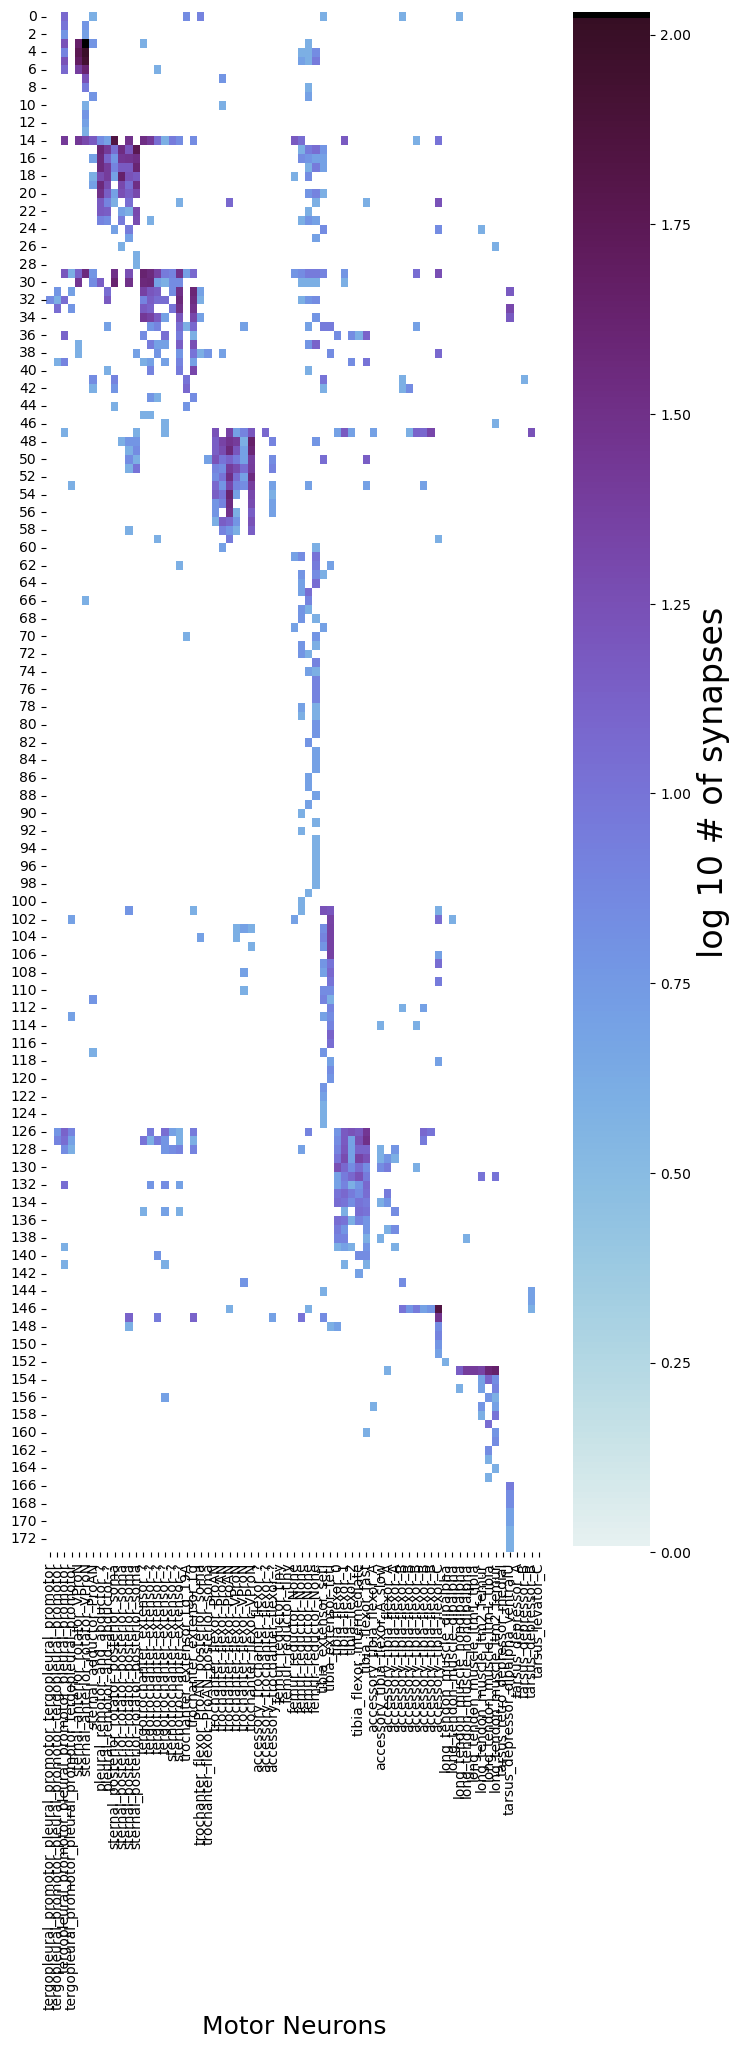

In [73]:
lbls = [i + '_' + str(j) for i,j in zip(no_glia.columns.get_level_values('muscle').to_list(),no_glia.columns.get_level_values('mn_identifier').to_list())]
lcl = no_glia.loc['sensory']

fig = plt.figure(1, figsize = [8,20])
cmap = utils.white_dense()
ax = sns.heatmap(np.log10(lcl.to_numpy()+1), xticklabels=lbls, cmap=cmap)
ax.set_rasterized(True)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'log 10 # of synapses', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
# plt.ylabel(ylabelstring, fontsize =18)
# plt.yticks(fontsize = 16)
# plt.xticks(fontsize = 16)
# plt.show()

# plt.xlabel(None)
# plt.ylabel(None)
# plt.xticks([])
# plt.yticks([])
plt.show()

In [74]:
lcl.min(axis=1)

preferred_pool           NT   classification_system  cell_type        segID             
coxa_promote             Ach  T1_L_Sensory           CO_hook_flx      648518346481857725    0
                                                     Hairplate        648518346514478279    0
                                                                      648518346491165987    0
coxa_rotate_adduct       Ach  ProAN_Afferent         Hairplate_CoHP4  648518346498320945    0
                                                                      648518346489643225    0
                                                                                           ..
tarsus_depress_ventralU  Ach  T1_L_Sensory           Bristle_neuron   648518346471994011    0
                                                                      648518346491817233    0
                              T1_L_Unsure            Unsure           648518346491175544    0
                              T1_L_Sensory           CO_hook_ext 

In [75]:
lcl = lcl.loc[(lcl>40).any(axis=1),:]

In [76]:
no_glia.sum(axis=0).to_list()

[1511,
 4106,
 4074,
 6533,
 6539,
 7347,
 1061,
 4647,
 5741,
 2130,
 2401,
 3973,
 5800,
 3724,
 3940,
 4290,
 4164,
 1620,
 5462,
 1745,
 4764,
 84,
 779,
 2671,
 3802,
 6291,
 2917,
 2984,
 6288,
 404,
 421,
 1254,
 19,
 52,
 745,
 947,
 2312,
 5230,
 6290,
 12813,
 4741,
 5515,
 6088,
 7665,
 8780,
 441,
 502,
 1182,
 1953,
 365,
 381,
 1435,
 1610,
 1758,
 6845,
 166,
 231,
 565,
 724,
 1319,
 3191,
 4870,
 5988,
 679,
 1255,
 621,
 283,
 1663,
 1616]

In [77]:
print(no_glia.index.get_level_values('cell_class').value_counts())

cell_class
local             678
intersegmental    304
descending        227
ascending         179
sensory           174
Name: count, dtype: int64


In [78]:
print(no_glia.index.get_level_values('preferred_pool').value_counts())

preferred_pool
trochanter_extend          249
tibia_ta_flex_A            216
ltm_B                      178
coxa_posterior             173
trochanter_flex            149
tibia_extend               138
coxa_rotate_adduct         115
femur_reduct               101
coxa_promote                94
tibia_ta_flex_C             86
tibia_ta_flex_B             38
tarsus_depress_ventralU     18
ltm_A                        4
tarsus_depress_medial        3
Name: count, dtype: int64


In [79]:
print(no_glia.index.get_level_values('NT').value_counts())

NT
Ach     474
GABA    195
Glu     180
Name: count, dtype: int64


In [80]:
print(no_glia.index.get_level_values('classification_system').value_counts())

classification_system
T1_L_Sensory      128
03A                89
22A                86
16B                69
13A                67
21A                44
04B                41
13B                40
08A                34
14A                33
20A                27
19A                27
12B                26
09A                25
01A                22
23B                17
17A                13
T1_L_Afferent      13
DProN_Unsure       11
01B                 8
ProAN_Afferent      4
T1_L_Unsure         4
07B                 3
VProN_Unsure        3
T1L_VProN           3
DProN_Afferent      3
VProN_Afferent      3
06A                 2
19B                 2
T2_R_Unsure         1
T2_L_Unsure         1
Name: count, dtype: int64


In [81]:
print(no_glia.index.get_level_values('cell_type').value_counts())

cell_type
03A                               89
16B                               69
13A                               67
22A_posterior                     57
Bristle_neuron                    57
                                  ..
17A_dorsal_post_boutons            1
17A_central_core_post_mirrored     1
17A_dorsal_lateral                 1
06A                                1
01B_primary                        1
Name: count, Length: 62, dtype: int64


In [82]:
# mpool_dict = utils.get_motor_pool_tuple_dict()
# pool_keys = [
#     'thorax_swing',
#     'thorax_stance',
#     'trochanter_extension',
#     'trochanter_flexion',
#     'femur_reductor',
#     'tibia_extensor',
#     'main_tibia_flexor',
#     # 'auxiliary_tibia_flexor_A',
#     'auxiliary_tibia_flexor_B',
#     'auxiliary_tibia_flexor_E',
#     'ltm',
#     'tarsus_depressor_med_venU',
#     'tarsus_depressor_noid',
#     ]

# a13a = no_glia.loc[(All,All,All,All,'13A')]
b13b = no_glia.loc[(All,All,All,All,'13B')]

In [83]:
b13b.index.get_level_values('segID').to_list()

[648518346479452114,
 648518346495020203,
 648518346488638136,
 648518346480818177,
 648518346490510428,
 648518346497880310,
 648518346495149194,
 648518346493379100,
 648518346494838549,
 648518346515287367,
 648518346483502500,
 648518346487925314,
 648518346478248917,
 648518346475605345,
 648518346502130026,
 648518346503974049,
 648518346489538905,
 648518346482932009,
 648518346488623855,
 648518346476749686,
 648518346488849336,
 648518346486783620,
 648518346493301424,
 648518346494034720,
 648518346475698816,
 648518346475676288,
 648518346496852092,
 648518346496516471,
 648518346498645524,
 648518346490190107,
 648518346512267455,
 648518346466234672,
 648518346496415549,
 648518346482939177,
 648518346489146858,
 648518346488261150,
 648518346506836514,
 648518346495576502,
 648518346486973436,
 648518346483437900]

In [84]:
client.materialize.get_tables()

['wing_motor_neuron_table_v0',
 'soma_jan2022',
 'synapses_nov2022',
 'proofread_second_pass',
 'cell_ids_v2',
 'motor_neuron_table_v7',
 'proofreading_status_jasper',
 'somas_dec2022',
 'upstream_feco_axons',
 'nucleus_mar2022',
 'left_t3_mn_order_reftable_v0',
 'downstream_feco_axons_v1',
 'synapse_regions_v1',
 'neuron_somas_dec2022',
 'topo_23b_table_v0',
 'downstream_10b_table_v0',
 'downstream_hair_plate_axon_table_v0',
 'proofread_by_andrewcook',
 'peripheral_nerves',
 'grooming_command_like_neurons_v1',
 'feco_axons_v0',
 'glia_somas_dec2022',
 'gustatory_downstream_t1l',
 'legcs_axons',
 'upstream_hair_plate_axon_table_v0',
 'sensory_admn_left',
 'left_t1_local_premotor_table_v5',
 'neck_connective',
 'right_t2_mn_cell_type_table_v0',
 'right_t3_mn_cell_type_table_v0',
 'abdominal_sensory_axon_table_v0',
 'neurotransmitter_hemilineage_table',
 'downstream_feco_axons_v0',
 'right_t2_mn_order_reftable_v0',
 'hair_plate_table',
 'downstream_bristle_table_v0',
 'bristle_axon_table

In [85]:
all_pre_to_mn_df.sum(axis=0).to_list()

[1652,
 4487,
 4513,
 6987,
 7096,
 7875,
 1143,
 5082,
 6172,
 2235,
 2534,
 4271,
 6213,
 4121,
 4474,
 4785,
 4826,
 1730,
 6091,
 1940,
 5231,
 99,
 857,
 2827,
 4032,
 6784,
 3043,
 3179,
 6567,
 421,
 450,
 1336,
 19,
 58,
 807,
 981,
 2451,
 5500,
 6892,
 14346,
 5073,
 6025,
 6511,
 8287,
 9626,
 475,
 520,
 1231,
 2126,
 386,
 400,
 1553,
 1797,
 1895,
 7752,
 173,
 253,
 600,
 786,
 1428,
 3556,
 5549,
 6860,
 715,
 1391,
 662,
 296,
 1823,
 1725]

# Show some connectivity 

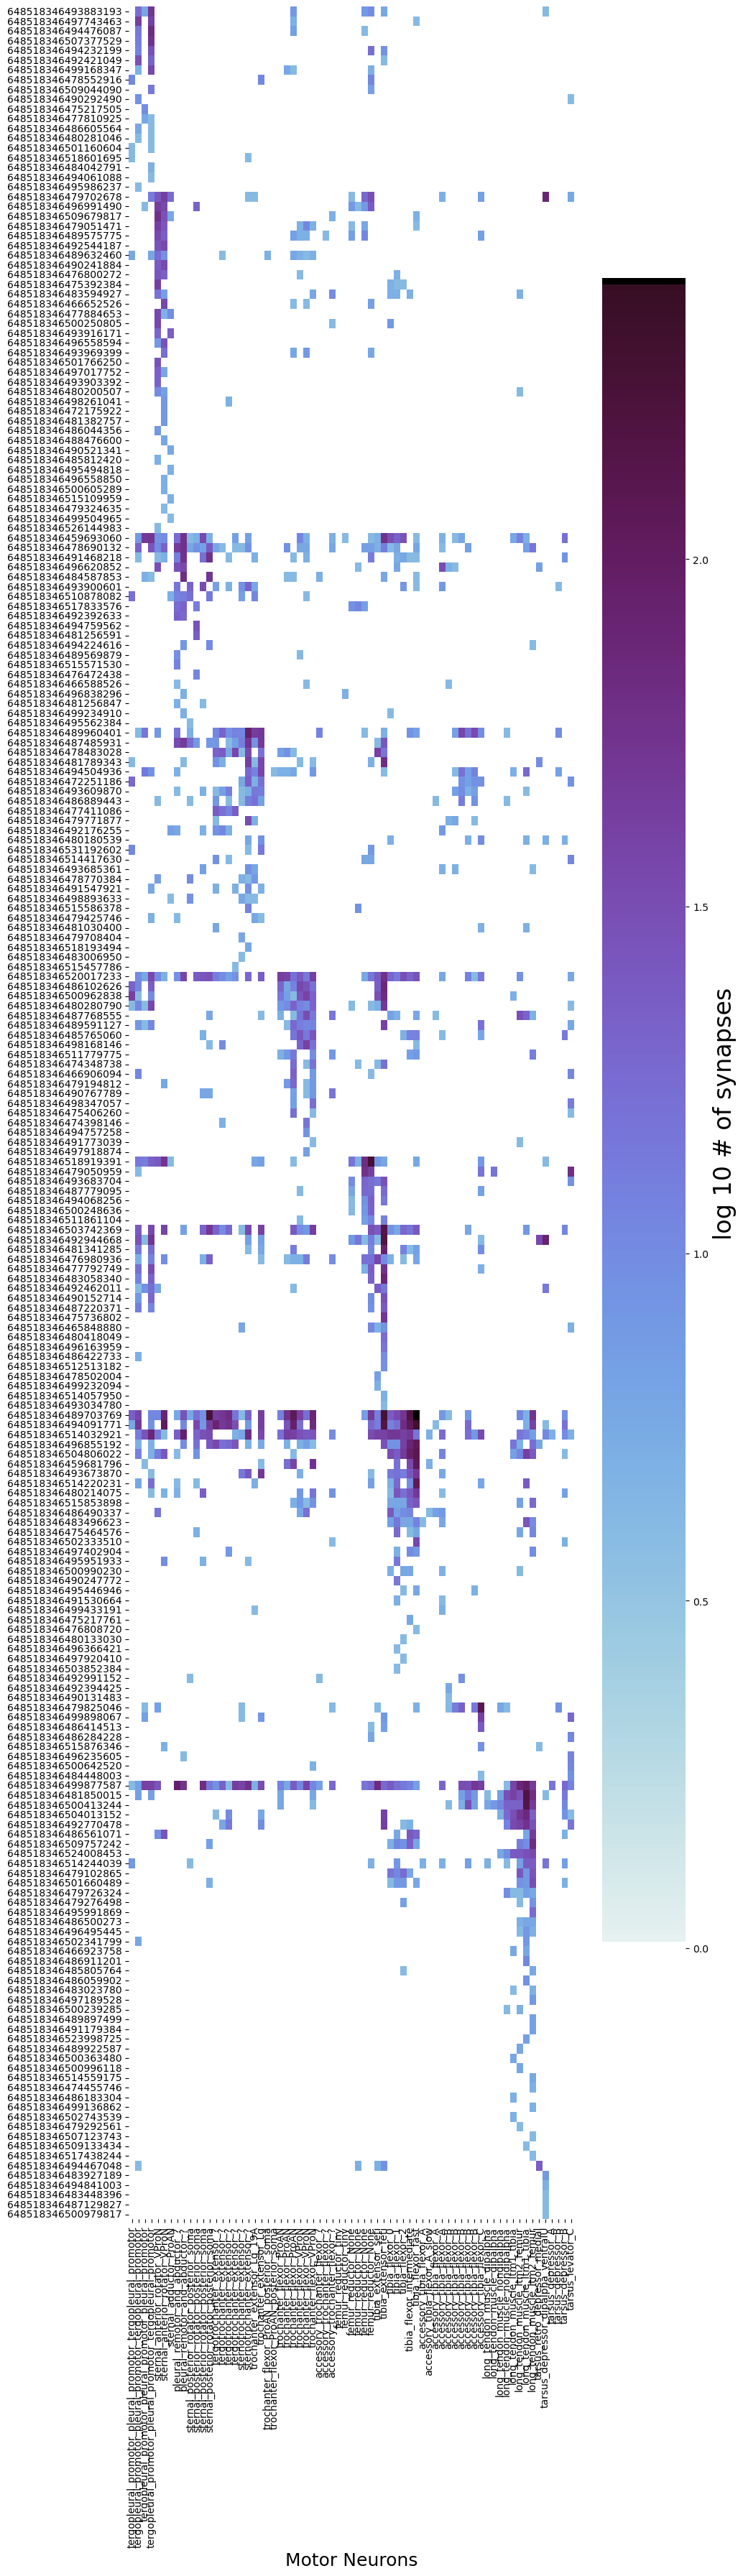

In [86]:
lbls = [i + '_' + str(j) for i,j in zip(no_glia.columns.get_level_values('muscle').to_list(),no_glia.columns.get_level_values('mn_identifier').to_list())]
dns = pre_to_mn_df.loc['descending']
snsry = no_glia.loc['sensory']
# lcl = lcl.loc[(lcl>40).any(axis=1),:]

fig = plt.figure(1, figsize = [10,40])
cmap = utils.white_dense()
ax = sns.heatmap(np.log10(dns.to_numpy()+1), xticklabels=lbls,yticklabels=dns.index.get_level_values('segID').to_list(), cmap=cmap)
ax.set_rasterized(True)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'log 10 # of synapses', size=24)
plt.xlabel('Motor Neurons', fontsize =18)
# plt.ylabel(ylabelstring, fontsize =18)
# plt.yticks(fontsize = 16)
# plt.xticks(fontsize = 16)
# plt.show()

# plt.xlabel(None)
# plt.ylabel(None)
# plt.xticks([])
# plt.yticks([])
plt.show()

snsry.to_csv('./dfs_saved/sensory_preMNs_20231018.csv')

In [87]:
lcl.iloc[100:152,38:56]
# lcl.to_csv('./dfs_saved/sensory_preMNs.csv')

Empty DataFrame
Columns: [(tibia_extend, ProLN, femur, tibia_extensor, seti, 38, 648518346494148128), (tibia_extend, ProLN, femur, tibia_extensor, feti, 39, 648518346507389983), (tibia_ta_flex_A, ProLN, femur, tibia_flexor, 0, 40, 648518346479239887), (tibia_ta_flex_A, ProLN, femur, tibia_flexor, 1, 41, 648518346498314906), (tibia_ta_flex_A, ProLN, femur, tibia_flexor, 2, 42, 648518346479055568), (tibia_ta_flex_A, ProLN, femur, tibia_flexor, intermediate, 43, 648518346496932836), (tibia_ta_flex_A, ProLN, femur, tibia_flexor, fast, 44, 648518346489543513), (tibia_ta_flex_A, ProLN, femur, accessory_tibia_flexor, A, 45, 648518346491774737), (tibia_ta_flex_A, ProLN, femur, accessory_tibia_flexor, A_slow, 46, 648518346496059082), (tibia_ta_flex_A, ProLN, femur, accessory_tibia_flexor, A, 47, 648518346478935892), (tibia_ta_flex_A, ProLN, femur, accessory_tibia_flexor, A, 48, 648518346477240264), (tibia_ta_flex_B, ProLN, femur, accessory_tibia_flexor, B, 49, 648518346480531926), (tibia_ta_flex_B, ProLN, femur, accessory_tibia_flexor, B, 50, 648518346466833006), (tibia_ta_flex_B, ProLN, femur, accessory_tibia_flexor, B, 51, 648518346479349137), (tibia_ta_flex_B, ProLN, femur, accessory_tibia_flexor, B, 52, 648518346477919895), (tibia_ta_flex_B, ProLN, femur, accessory_tibia_flexor, B, 53, 648518346494476935), (tibia_ta_flex_C, ProLN, femur, accessory_tibia_flexor, C, 54, 648518346486971900), (ltm_A, ProLN, ltm, long_tendon_muscle, dipalpha, 55, 648518346521586425)]
Index: []

# Load the recent df

In [88]:
import connectome_create
pre_to_mn_df = connectome_create.load_pre_to_mn_df(ext='matched_typed_with_nt')
pre_to_mn_df.shape

Found pickle file .\dfs_pre_to_mn\pre_to_mn_df_matched_typed_with_nt_20240627.pkl


(1562, 69)

In [89]:
pre_to_mn_df.to_csv('./dfs_saved/pre_mn_df_matched_typed_with_nt.csv')

In [90]:
pre_to_mn_df.loc[pre_to_mn_df.index.get_level_values('segID')==648518346499877587]

module                                                                                                     coxa_promote  \
nerve                                                                                                             DProN   
muscle_origin                                                                                                    thorax   
muscle                                                                           tergopleural_promotor_pleural_promotor   
mn_identifier                                                                                     tergopleural_promotor   
order                                                                                                                 0   
segID                                                                                                648518346487756866   
cell_class preferred_pool NT  classification_system cell_type segID                                                       
descending ltm_B          NaN NaN                   NaN       648518346499877587                                      3   

module                                                                                               \
nerve                                                                                                 
muscle_origin                                                                                         
muscle                                                                                                
mn_identifier                                                                                         
order                                                                                             1   
segID                                                                            648518346491659326   
cell_class preferred_pool NT  classification_system cell_type segID                                   
descending ltm_B          NaN NaN                   NaN       648518346499877587                  6   

module                                                                                               \
nerve                                                                                                 
muscle_origin                                                                                         
muscle                                                                                                
mn_identifier                                                                      pleural_promotor   
order                                                                                             2   
segID                                                                            648518346517437482   
cell_class preferred_pool NT  classification_system cell_type segID                                   
descending ltm_B          NaN NaN                   NaN       648518346499877587                 40   

module                                                                                                  \
nerve                                                                                                    
muscle_origin                                                                                            
muscle                                                                                                   
mn_identifier                                                                    tergopleural_promotor   
order                                                                                                3   
segID                                                                               648518346500725685   
cell_class preferred_pool NT  classification_system cell_type segID                                      
descending ltm_B          NaN NaN                   NaN       648518346499877587                    39   

module                                                                           

In [91]:
pre_to_mn_df.loc[pre_to_mn_df.index.get_level_values('segID')==648518346526268631]

Empty DataFrame
Columns: [(coxa_promote, DProN, thorax, tergopleural_promotor_pleural_promotor, tergopleural_promotor, 0, 648518346487756866), (coxa_promote, DProN, thorax, tergopleural_promotor_pleural_promotor, tergopleural_promotor, 1, 648518346491659326), (coxa_promote, DProN, thorax, tergopleural_promotor_pleural_promotor, pleural_promotor, 2, 648518346517437482), (coxa_promote, DProN, thorax, tergopleural_promotor_pleural_promotor, tergopleural_promotor, 3, 648518346500725685), (coxa_rotate_adduct, VProN, thorax, sternal_anterior_rotator, VProN, 4, 648518346479325585), (coxa_rotate_adduct, VProN, thorax, sternal_anterior_rotator, VProN, 5, 648518346487504531), (coxa_rotate_adduct, ProAN, thorax, sternal_adductor, ProAN, 6, 648518346478125293), (coxa_posterior, ProAN, thorax, pleural_remotor_and_abductor, ?, 7, 648518346479077839), (coxa_posterior, ProAN, thorax, pleural_remotor_and_abductor, ?, 8, 648518346483047589), (coxa_posterior, ProAN, thorax, sternal_posterior_rotator, posterior_soma, 9, 648518346490738941), (coxa_posterior, ProAN, thorax, sternal_posterior_rotator, posterior_soma, 10, 648518346489802071), (coxa_posterior, ProAN, thorax, sternal_posterior_rotator, posterior_soma, 11, 648518346491281272), (coxa_posterior, ProAN, thorax, sternal_posterior_rotator, posterior_soma, 12, 648518346488854257), (trochanter_extend, VProN, thorax, tergotrochanter_extensor, ?, 13, 648518346514458155), (trochanter_extend, VProN, thorax, tergotrochanter_extensor, ?, 14, 648518346496195084), (trochanter_extend, VProN, thorax, tergotrochanter_extensor, ?, 15, 648518346520685366), (trochanter_extend, VProN, thorax, tergotrochanter_extensor, ?, 16, 648518346486850812), (trochanter_extend, VProN, thorax, sternotrochanter_extensor, ?, 17, 648518346514306270), (trochanter_extend, VProN, thorax, sternotrochanter_extensor, ?, 18, 648518346504092878), (trochanter_extend, ProLN, coxa, trochanter_extensor, Lg_19A, 19, 648518346502617767), (trochanter_extend, ProLN, coxa, trochanter_extensor, Lg, 20, 648518346497891062), (trochanter_flex, ProAN, coxa, trochanter_flexor, ProAN_posterior_soma, 21, 648518346477140752), (trochanter_flex, ProAN, coxa, trochanter_flexor, ProAN_posterior_soma, 22, 648518346481524623), (trochanter_flex, ProAN, coxa, trochanter_flexor, ProAN, 23, 648518346466168368), (trochanter_flex, ProAN, coxa, trochanter_flexor, ProAN, 24, 648518346495952784), (trochanter_flex, ProAN, coxa, trochanter_flexor, ProAN, 25, 648518346505044358), (trochanter_flex, VProN, coxa, trochanter_flexor, VProN, 26, 648518346488137239), (trochanter_flex, VProN, coxa, trochanter_flexor, VProN, 27, 648518346483445438), (trochanter_flex, VProN, coxa, trochanter_flexor, VProN, 28, 648518346488873565), (trochanter_flex, ProLN, coxa, accessory_trochanter_flexor, ?, 29, 648518346504230496), (trochanter_flex, ProLN, coxa, accessory_trochanter_flexor, ?, 30, 648518346490899373), (trochanter_flex, ProLN, coxa, accessory_trochanter_flexor, ?, 31, 648518346479197392), (femur_reduct, ProLN, trochanter, femur_reductor, tiny, 32, 648518346487743188), (femur_reduct, ProLN, trochanter, femur_reductor, tiny, 33, 648518346486427296), (femur_reduct, ProLN, trochanter, femur_reductor, None, 34, 648518346519022303), (femur_reduct, ProLN, trochanter, femur_reductor, None, 35, 648518346503310971), (femur_reduct, ProLN, trochanter, femur_reductor, None, 36, 648518346477726990), (femur_reduct, ProLN, trochanter, femur_reductor, None, 37, 648518346494195703), (tibia_extend, ProLN, femur, tibia_extensor, seti, 38, 648518346494148128), (tibia_extend, ProLN, femur, tibia_extensor, feti, 39, 648518346507389983), (tibia_ta_flex_A, ProLN, femur, tibia_flexor, 0, 40, 648518346479239887), (tibia_ta_flex_A, ProLN, femur, tibia_flexor, 1, 41, 648518346498314906), (tibia_ta_flex_A, ProLN, femur, tibia_flexor, 2, 42, 648518346479055568), (tibia_ta_flex_A, ProLN, femur, tibia_flexor, intermediate, 43, 648518346496932836), (tibia_ta_flex_A, ProLN, femur, tibia_flexor, fast, 44, 648518